In [1]:
from __future__ import print_function, division, absolute_import
# import tensorflow as tf
# from keras.backend.tensorflow_backend import set_session
# config = tf.ConfigProto()
# config.gpu_options.per_process_gpu_memory_fraction = 0.4
# set_session(tf.Session(config=config))
# from clr_callback import CyclicLR
# import dill
from AudioDataGenerator import AudioDataGenerator
import os
import numpy as np
np.random.seed(1)
from tensorflow import set_random_seed
set_random_seed(1)
import pandas as pd
import tables
from datetime import datetime
import argparse
from keras.layers import Input, Conv1D, MaxPooling1D, Dense, Dropout, Flatten, Activation, AveragePooling1D
from keras import initializers
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate
from keras.models import Model
from keras.regularizers import l2
from keras.constraints import max_norm
from keras.optimizers import Adam  # Nadam, Adamax
from keras.callbacks import TensorBoard, Callback, ReduceLROnPlateau
from keras.callbacks import LearningRateScheduler, ModelCheckpoint, CSVLogger
from keras import backend as K
from keras.utils import plot_model
from custom_layers import Conv1D_zerophase_linear, Conv1D_linearphase, Conv1D_zerophase,\
    DCT1D, Conv1D_gammatone, Conv1D_linearphaseType
from heartnet_v1 import log_macc, write_meta, compute_weight, reshape_folds, results_log
from utils import DenseNet
from sklearn.metrics import confusion_matrix
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns
from keras.losses import categorical_crossentropy
sns.set()
import ast # for list import

Using TensorFlow backend.


In [2]:
def branch(input_tensor,num_filt,kernel_size,random_seed,padding,bias,maxnorm,l2_reg,
           eps,bn_momentum,activation_function,dropout_rate,subsam,trainable):

    num_filt1, num_filt2 = num_filt
    t = Conv1D(num_filt1, kernel_size=kernel_size,
                kernel_initializer=initializers.he_normal(seed=random_seed),
                padding=padding,
                use_bias=bias,
                kernel_constraint=max_norm(maxnorm),
                trainable=trainable,
                kernel_regularizer=l2(l2_reg))(input_tensor)
    t = BatchNormalization(epsilon=eps, momentum=bn_momentum, axis=-1)(t)
    t = Activation(activation_function)(t)
    t = Dropout(rate=dropout_rate, seed=random_seed)(t)
    t = MaxPooling1D(pool_size=subsam)(t)
    t = Conv1D(num_filt2, kernel_size=kernel_size,
               kernel_initializer=initializers.he_normal(seed=random_seed),
               padding=padding,
               use_bias=bias,
               trainable=trainable,
               kernel_constraint=max_norm(maxnorm),
               kernel_regularizer=l2(l2_reg))(t)
    t = BatchNormalization(epsilon=eps, momentum=bn_momentum, axis=-1)(t)
    t = Activation(activation_function)(t)
    t = Dropout(rate=dropout_rate, seed=random_seed)(t)
    t = MaxPooling1D(pool_size=subsam)(t)
    # t = Flatten()(t)
    return t

In [3]:
foldname='fold1_noFIR'


In [4]:
random_seed=1
batch_size=64
fold_dir = '/media/taufiq/Data1/heart_sound/feature/segmented_noFIR/folds_dec_2018/'
log_dir= '/media/taufiq/Data/heart_sound/Heart_Sound/codes/logs/'
bn_momentum = 0.99
eps= 1.1e-5
bias=False
l2_reg=0.
# l2_reg_dense=0.
kernel_size=5
maxnorm=10000.
dropout_rate=0.5
dropout_rate_dense=0.
padding='valid'
activation_function='relu'
subsam=2
load_path=False
lr=0.0012843784 
lr_decay=0.0001132885
FIR_train=True
num_filt=(8,4)
num_dense=20
params = dict()
print("values initialized")

model_dir = '/media/taufiq/Data1/heart_sound/models/'
fold_dir = '/media/taufiq/Data1/heart_sound/feature/segmented_noFIR/folds_dec_2018/'
log_name = foldname + ' ' + str(datetime.now())
log_dir = '/media/taufiq/Data1/heart_sound/logs/'
if not os.path.exists(model_dir + log_name):
    os.makedirs(model_dir + log_name)
checkpoint_name = model_dir + log_name + "/" + 'weights.{epoch:04d}-{val_acc:.4f}.hdf5'
results_path = '/media/taufiq/Data1/heart_sound/results_2class.csv'

num_filt = (8, 4)
num_dense = 20

bn_momentum = 0.99
eps = 1.1e-5
bias = False
l2_reg = 0.04864911065093751
l2_reg_dense = 0.
kernel_size = 5
maxnorm = 10000.
dropout_rate = 0.5
dropout_rate_dense = 0.
padding = 'valid'
activation_function = 'relu'
subsam = 2
FIR_train= True
trainable = True
decision = 'majority'  # Decision algorithm for inference over total recording ('majority','confidence')

# lr =  0.00125 ## After bayesian optimization

###### lr_decay optimization ######
lr_decay =0.0001132885

values initialized


In [5]:
feat = tables.open_file(fold_dir + foldname + '.mat')
x_train = feat.root.trainX[:]
y_train = feat.root.trainY[0, :]
x_val = feat.root.valX[:]
y_val = feat.root.valY[0, :]
train_parts = feat.root.train_parts[:]
val_parts = feat.root.val_parts[0, :]

############## Relabeling ################

for i in range(0, y_train.shape[0]):
    if y_train[i] == -1:
        y_train[i] = 0  ## Label 0 for normal 1 for abnormal
for i in range(0, y_val.shape[0]):
    if y_val[i] == -1:
        y_val[i] = 0

############# Parse Database names ########

train_files = []
for each in feat.root.train_files[:][0]:
    train_files.append(chr(each))
print(len(train_files))
val_files = []
for each in feat.root.val_files[:][0]:
    val_files.append(chr(each))
print(len(val_files))

################### Reshaping ############

x_train, y_train, x_val, y_val = reshape_folds(x_train, x_val, y_train, y_val)
y_train = to_categorical(y_train, num_classes=2)
y_val = to_categorical(y_val, num_classes=2)

76881
9639
(76881, 2500, 1)
(76881, 1)
(9639, 2500, 1)
(9639, 1)


In [6]:
datagen = AudioDataGenerator(shift=.1,
                             # roll_range=.1,
                             # fill_mode='reflect',
                             # featurewise_center=True,
                             # zoom_range=.1,
                             # zca_whitening=True,
                             # samplewise_center=True,
                             # samplewise_std_normalization=True,
                             )

In [7]:
def heartnet(load_path,activation_function='relu', bn_momentum=0.99,
             bias=False, dropout_rate=0.5, dropout_rate_dense=0.0,
             eps=1.1e-5, kernel_size=5, l2_reg=0.0, l2_reg_dense=0.0,
             lr=0.0012843784, lr_decay=0.0001132885, maxnorm=10000.,
             padding='valid', random_seed=1, subsam=2, num_filt=(8, 4),
             num_dense=20,FIR_train=False,trainable=True,type_=1,args=1):

    input = Input(shape=(2500, 1))

    coeff_path = '/media/taufiq/Data1/heart_sound/heartnetTransfer/filterbankcoeff60.mat'
    coeff = tables.open_file(coeff_path)
    b1 = coeff.root.b1[:]
    b1 = np.hstack(b1)
    b1 = np.reshape(b1, [b1.shape[0], 1, 1])

    b2 = coeff.root.b2[:]
    b2 = np.hstack(b2)
    b2 = np.reshape(b2, [b2.shape[0], 1, 1])

    b3 = coeff.root.b3[:]
    b3 = np.hstack(b3)
    b3 = np.reshape(b3, [b3.shape[0], 1, 1])

    b4 = coeff.root.b4[:]
    b4 = np.hstack(b4)
    b4 = np.reshape(b4, [b4.shape[0], 1, 1])

    ## Conv1D_linearphase

    # input1 = Conv1D_linearphase(1 ,61, use_bias=False,
    #                 # kernel_initializer=initializers.he_normal(random_seed),
    #                 weights=[b1[30:]],
    #                 padding='same',trainable=FIR_train)(input)
    # input2 = Conv1D_linearphase(1, 61, use_bias=False,
    #                 # kernel_initializer=initializers.he_normal(random_seed),
    #                 weights=[b2[30:]],
    #                 padding='same',trainable=FIR_train)(input)
    # input3 = Conv1D_linearphase(1, 61, use_bias=False,
    #                 # kernel_initializer=initializers.he_normal(random_seed),
    #                 weights=[b3[30:]],
    #                 padding='same',trainable=FIR_train)(input)
    # input4 = Conv1D_linearphase(1, 61, use_bias=False,
    #                 # kernel_initializer=initializers.he_normal(random_seed),
    #                 weights=[b4[30:]],
    #                 padding='same',trainable=FIR_train)(input)

    ## Conv1D_linearphase Anti-Symmetric
    #

    if type_ % 2:
        weight_idx = 30
    else:
        weight_idx = 31

    input1 = Conv1D_linearphaseType(1 ,61, use_bias=False,
                    # kernel_initializer=initializers.he_normal(random_seed),
                    weights=[b1[weight_idx:]],
                    padding='same',trainable=FIR_train, type = type_)(input)
    input2 = Conv1D_linearphaseType(1, 61, use_bias=False,
                    # kernel_initializer=initializers.he_normal(random_seed),
                    weights=[b2[weight_idx:]],
                    padding='same',trainable=FIR_train, type = type_)(input)
    input3 = Conv1D_linearphaseType(1, 61, use_bias=False,
                    # kernel_initializer=initializers.he_normal(random_seed),
                    weights=[b3[weight_idx:]],
                    padding='same',trainable=FIR_train, type = type_)(input)
    input4 = Conv1D_linearphaseType(1, 61, use_bias=False,
                    # kernel_initializer=initializers.he_normal(random_seed),
                    weights=[b4[weight_idx:]],
                    padding='same',trainable=FIR_train, type = type_)(input)

    #Conv1D_gammatone

    # input1 = Conv1D_gammatone(kernel_size=81,filters=1,fsHz=1000,use_bias=False,padding='same')(input)
    # input2 = Conv1D_gammatone(kernel_size=81,filters=1,fsHz=1000,use_bias=False,padding='same')(input)
    # input3 = Conv1D_gammatone(kernel_size=81,filters=1,fsHz=1000,use_bias=False,padding='same')(input)
    # input4 = Conv1D_gammatone(kernel_size=81,filters=1,fsHz=1000,use_bias=False,padding='same')(input)

    t1 = branch(input1,num_filt,kernel_size,random_seed,padding,bias,maxnorm,l2_reg,
           eps,bn_momentum,activation_function,dropout_rate,subsam,trainable)
    t2 = branch(input2,num_filt,kernel_size,random_seed,padding,bias,maxnorm,l2_reg,
           eps,bn_momentum,activation_function,dropout_rate,subsam,trainable)
    t3 = branch(input3,num_filt,kernel_size,random_seed,padding,bias,maxnorm,l2_reg,
           eps,bn_momentum,activation_function,dropout_rate,subsam,trainable)
    t4 = branch(input4,num_filt,kernel_size,random_seed,padding,bias,maxnorm,l2_reg,
           eps,bn_momentum,activation_function,dropout_rate,subsam,trainable)

    merged = Concatenate(axis=-1)([t1, t2, t3, t4])
    merged = DenseNet(merged,
                      depth=int(3*args[0]+4),
                      nb_dense_block=args[1],
                      growth_rate=int(args[2]),
#                       kernel_size=args[3],
                      kernel_size=5,
#                       nb_filter=args[4],
                      nb_filter=16,
#                       dropout_rate=args[5],
                      dropout_rate=dropout_rate,
                     )
    # 7,4,4,5,16; 7,1,4,5,16

    # merged = DCT1D()(merged)
    merged = Flatten()(merged)
    merged = Dense(num_dense,
                   activation=activation_function,
                   kernel_initializer=initializers.he_normal(seed=random_seed),
                   use_bias=bias,
                   kernel_constraint=max_norm(maxnorm),
                   kernel_regularizer=l2(l2_reg_dense))(merged)
    # merged = BatchNormalization(epsilon=eps,momentum=bn_momentum,axis=-1) (merged)
    # merged = Activation(activation_function)(merged)
    merged = Dropout(rate=dropout_rate_dense, seed=random_seed)(merged)
    merged = Dense(2, activation='softmax')(merged)

    model = Model(inputs=input, outputs=merged)

    if load_path:  # If path for loading model was specified
        model.load_weights(filepath=load_path, by_name=False)

    adam = Adam(lr=lr, decay=lr_decay)
    model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [9]:
def objective(args):
    print("args {}".format(args))
    
    log_name = "hyperopt-{}".format(args) + str(datetime.now())
    if not os.path.exists(model_dir + log_name):
        os.makedirs(model_dir + log_name)
    checkpoint_name = model_dir + log_name + "/" + 'weights.{epoch:04d}-{val_acc:.4f}.hdf5'
    
    
    csv_logger = CSVLogger(log_dir + log_name + '/training.csv')
    tensbd = TensorBoard(log_dir=log_dir + log_name,
                            batch_size=batch_size,
                            write_grads=False)
    modelcheckpnt = ModelCheckpoint(filepath=checkpoint_name,
                                monitor='val_F1',
                                save_best_only=True, mode='max')
    
    model = heartnet(load_path,activation_function, bn_momentum, bias, dropout_rate, dropout_rate_dense,
                         eps, kernel_size, l2_reg, l2_reg_dense, lr, lr_decay, maxnorm,
                         padding, random_seed, subsam, num_filt, num_dense, FIR_train, trainable, 1, args)
#     model.summary()
    model.fit_generator(datagen.flow(x_train, y_train, batch_size, shuffle=True,
                                     seed=random_seed),
                            steps_per_epoch=len(x_train) // batch_size,
                            # max_queue_size=20,
                            use_multiprocessing=False,
                            epochs=30,
                            verbose=1,
                            shuffle=True,
                            callbacks=[modelcheckpnt,
                                       log_macc(val_parts, decision=decision,verbose=1, val_files=val_files),
                                       tensbd, csv_logger],
                            validation_data=(x_val, y_val),
                            initial_epoch=0,
                            )
    y_pred = model.predict(x_val)
    loss = K.eval(K.mean(K.variable(K.eval(categorical_crossentropy(K.variable(y_val),K.variable(y_pred))))))
    params[str(args)]=loss
    print("Loss: %f" % loss)
    return loss    

## Hyperopt for TPE Optimization

In [20]:
from hyperopt import hp, Trials, fmin, tpe
trials = Trials()
best = fmin(objective,
    space=[hp.quniform('depth',1,30,1),
           hp.choice('num_block',[1,2,3]),
           hp.quniform('growth',1,20,1),
#            hp.choice('kernel_size',[3,5,7]),
#            hp.choice('num_filters',[8,16,32]),
#            hp.normal('dropout',0.4,0.1)
          ],
    algo=tpe.suggest,
    max_evals=20,
    trials=trials)

args (23.0, 1, 4.0)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 2500, 1)      0                                            
__________________________________________________________________________________________________
conv1d_linearphase_type_5 (Conv (None, 2500, 1)      31          input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_linearphase_type_6 (Conv (None, 2500, 1)      31          input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_linearphase_type_7 (Conv (None, 2500, 1)      31          input_2[0][0]                    
_________________________________________________________________________________________

Epoch 1/20
6710/6710 [==============================] - 5s 721us/step
TN:96,FP:50,FN:50,TP:88,Macc:0.647607652813,F1:0.637675608638
Epoch 2/20
6710/6710 [==============================] - 3s 513us/step
TN:72,FP:74,FN:27,TP:111,Macc:0.648749204874,F1:0.68730107123
Epoch 3/20
6710/6710 [==============================] - 3s 510us/step
TN:57,FP:89,FN:14,TP:124,Macc:0.644480791252,F1:0.70654741342
Epoch 4/20
6710/6710 [==============================] - 4s 523us/step
TN:47,FP:99,FN:4,TP:134,Macc:0.64646609966,F1:0.722366785486
Epoch 5/20
6710/6710 [==============================] - 3s 510us/step
TN:39,FP:107,FN:0,TP:138,Macc:0.633561593918,F1:0.720621519768
Epoch 6/20
6710/6710 [==============================] - 3s 513us/step
TN:67,FP:79,FN:24,TP:114,Macc:0.642495482844,F1:0.688816358381
Epoch 7/20
6710/6710 [==============================] - 4s 525us/step
TN:45,FP:101,FN:4,TP:134,Macc:0.639616785107,F1:0.718493489129
Epoch 8/20
6710/6710 [==============================] - 4s 526us/step
TN:3

Epoch 1/20
6710/6710 [==============================] - 7s 1ms/step
TN:37,FP:109,FN:7,TP:131,Macc:0.601349962546,F1:0.693116553297
Epoch 2/20
6710/6710 [==============================] - 5s 718us/step
TN:49,FP:97,FN:12,TP:126,Macc:0.624329909276,F1:0.698055704246
Epoch 3/20
6710/6710 [==============================] - 5s 715us/step
TN:27,FP:119,FN:2,TP:136,Macc:0.585219330369,F1:0.692106908051
Epoch 4/20
6710/6710 [==============================] - 5s 740us/step
TN:23,FP:123,FN:0,TP:138,Macc:0.578767077498,F1:0.691724307873
Epoch 5/20
6710/6710 [==============================] - 5s 729us/step
TN:28,FP:118,FN:2,TP:136,Macc:0.588643987645,F1:0.693872493737
Epoch 6/20
6710/6710 [==============================] - 5s 709us/step
TN:45,FP:101,FN:5,TP:133,Macc:0.63599359699,F1:0.715048587475
Epoch 7/20
6710/6710 [==============================] - 5s 724us/step
TN:36,FP:110,FN:2,TP:136,Macc:0.616041245855,F1:0.708328227846
Epoch 8/20
6710/6710 [==============================] - 5s 739us/step
TN

Epoch 1/20
6710/6710 [==============================] - 10s 1ms/step
TN:146,FP:0,FN:138,TP:0,Macc:0.499999962329,F1:0.0
Epoch 2/20
6710/6710 [==============================] - 7s 1ms/step
TN:146,FP:0,FN:138,TP:0,Macc:0.499999962329,F1:0.0
Epoch 3/20
6710/6710 [==============================] - 7s 1ms/step
TN:68,FP:78,FN:26,TP:112,Macc:0.638673763886,F1:0.68292142174
Epoch 4/20
6710/6710 [==============================] - 7s 1ms/step
TN:77,FP:69,FN:26,TP:112,Macc:0.669495679372,F1:0.702188908916
Epoch 5/20
6710/6710 [==============================] - 7s 1ms/step
TN:73,FP:73,FN:32,TP:106,Macc:0.634057921566,F1:0.668764261724
Epoch 6/20
6710/6710 [==============================] - 7s 1ms/step
TN:32,FP:114,FN:12,TP:126,Macc:0.56611073558,F1:0.666661528384
Epoch 7/20
6710/6710 [==============================] - 7s 1ms/step
TN:43,FP:103,FN:10,TP:128,Macc:0.611028341853,F1:0.693761745707
Epoch 8/20
6710/6710 [==============================] - 7s 1ms/step
TN:82,FP:64,FN:36,TP:102,Macc:0.650387

Epoch 1/20
6710/6710 [==============================] - 15s 2ms/step
TN:30,FP:116,FN:4,TP:134,Macc:0.588246925964,F1:0.690716568641
Epoch 2/20
6710/6710 [==============================] - 10s 1ms/step
TN:60,FP:86,FN:16,TP:122,Macc:0.647508386847,F1:0.705196992455
Epoch 3/20
6710/6710 [==============================] - 10s 1ms/step
TN:37,FP:109,FN:6,TP:132,Macc:0.604973150663,F1:0.696564786665
Epoch 4/20
6710/6710 [==============================] - 10s 1ms/step
TN:36,FP:110,FN:1,TP:137,Macc:0.619664433972,F1:0.71168321191
Epoch 5/20
6710/6710 [==============================] - 10s 1ms/step
TN:119,FP:27,FN:68,TP:70,Macc:0.66115738406,F1:0.595739292542
Epoch 6/20
6710/6710 [==============================] - 10s 1ms/step
TN:142,FP:4,FN:118,TP:20,Macc:0.558765095564,F1:0.24691077034
Epoch 7/20
6710/6710 [==============================] - 10s 1ms/step
TN:139,FP:7,FN:113,TP:25,Macc:0.56660706432,F1:0.294114247374
Epoch 8/20
6710/6710 [==============================] - 10s 1ms/step
TN:112,FP:3

Epoch 1/20
6710/6710 [==============================] - 7s 1ms/step
TN:66,FP:80,FN:19,TP:119,Macc:0.657186766153,F1:0.706226088145
Epoch 2/20
6710/6710 [==============================] - 3s 444us/step
TN:52,FP:94,FN:10,TP:128,Macc:0.641850257339,F1:0.711105867137
Epoch 3/20
6710/6710 [==============================] - 3s 435us/step
TN:28,FP:118,FN:2,TP:136,Macc:0.588643987645,F1:0.693872493737
Epoch 4/20
6710/6710 [==============================] - 3s 427us/step
TN:54,FP:92,FN:25,TP:113,Macc:0.594351750136,F1:0.658886795918
Epoch 5/20
6710/6710 [==============================] - 3s 426us/step
TN:30,FP:116,FN:3,TP:135,Macc:0.591870114081,F1:0.694082328491
Epoch 6/20
6710/6710 [==============================] - 3s 438us/step
TN:71,FP:75,FN:34,TP:104,Macc:0.619962230779,F1:0.656145966071
Epoch 7/20
6710/6710 [==============================] - 3s 415us/step
TN:121,FP:25,FN:71,TP:67,Macc:0.657137134262,F1:0.582603359972
Epoch 8/20
6710/6710 [==============================] - 3s 449us/step
T

Epoch 1/20
6710/6710 [==============================] - 7s 1ms/step
TN:140,FP:6,FN:126,TP:12,Macc:0.522930276075,F1:0.15384388662
Epoch 2/20
6710/6710 [==============================] - 3s 397us/step
TN:57,FP:89,FN:20,TP:118,Macc:0.62274166255,F1:0.684052647434
Epoch 3/20
6710/6710 [==============================] - 3s 413us/step
TN:57,FP:89,FN:10,TP:128,Macc:0.65897354372,F1:0.721121488282
Epoch 4/20
6710/6710 [==============================] - 3s 399us/step
TN:66,FP:80,FN:13,TP:125,Macc:0.678925894855,F1:0.728857636907
Epoch 5/20
6710/6710 [==============================] - 3s 397us/step
TN:89,FP:57,FN:42,TP:96,Macc:0.652620556815,F1:0.659788279211
Epoch 6/20
6710/6710 [==============================] - 3s 388us/step
TN:72,FP:74,FN:28,TP:110,Macc:0.645126016757,F1:0.683224379272
Epoch 7/20
6710/6710 [==============================] - 3s 418us/step
TN:76,FP:70,FN:29,TP:109,Macc:0.655201457745,F1:0.687691705204
Epoch 8/20
6710/6710 [==============================] - 3s 396us/step
TN:76

Epoch 1/20
6710/6710 [==============================] - 6s 930us/step
TN:110,FP:36,FN:74,TP:64,Macc:0.608596339872,F1:0.537809716599
Epoch 2/20
6710/6710 [==============================] - 2s 277us/step
TN:85,FP:61,FN:38,TP:100,Macc:0.653414680178,F1:0.668890804443
Epoch 3/20
6710/6710 [==============================] - 2s 309us/step
TN:81,FP:65,FN:39,TP:99,Macc:0.636092862956,F1:0.655623632123
Epoch 4/20
6710/6710 [==============================] - 2s 304us/step
TN:90,FP:56,FN:46,TP:92,Macc:0.641552461623,F1:0.643351100639
Epoch 5/20
6710/6710 [==============================] - 2s 311us/step
TN:80,FP:66,FN:34,TP:104,Macc:0.650784146265,F1:0.6753191865
Epoch 6/20
6710/6710 [==============================] - 2s 272us/step
TN:78,FP:68,FN:27,TP:111,Macc:0.669297148532,F1:0.700310000858
Epoch 7/20
6710/6710 [==============================] - 2s 286us/step
TN:71,FP:75,FN:27,TP:111,Macc:0.645324547598,F1:0.685179759416
Epoch 8/20
6710/6710 [==============================] - 2s 283us/step
TN:

Epoch 1/20
6710/6710 [==============================] - 10s 2ms/step
TN:71,FP:75,FN:16,TP:122,Macc:0.685179616885,F1:0.728352831761
Epoch 2/20
6710/6710 [==============================] - 5s 796us/step
TN:72,FP:74,FN:34,TP:104,Macc:0.623386888055,F1:0.658222390447
Epoch 3/20
6710/6710 [==============================] - 5s 765us/step
TN:94,FP:52,FN:39,TP:99,Macc:0.680613407547,F1:0.685115566285
Epoch 4/20
6710/6710 [==============================] - 5s 767us/step
TN:92,FP:54,FN:45,TP:93,Macc:0.652024964293,F1:0.6526260341
Epoch 5/20
6710/6710 [==============================] - 5s 759us/step
TN:61,FP:85,FN:17,TP:121,Macc:0.647309856006,F1:0.703483042056
Epoch 6/20
6710/6710 [==============================] - 5s 776us/step
TN:76,FP:70,FN:29,TP:109,Macc:0.655201457745,F1:0.687691705204
Epoch 7/20
6710/6710 [==============================] - 5s 750us/step
TN:95,FP:51,FN:49,TP:89,Macc:0.647806183654,F1:0.640282219446
Epoch 8/20
6710/6710 [==============================] - 5s 750us/step
TN:93

Epoch 1/20
6710/6710 [==============================] - 21s 3ms/step
TN:146,FP:0,FN:138,TP:0,Macc:0.499999962329,F1:0.0
Epoch 2/20
6710/6710 [==============================] - 14s 2ms/step
TN:37,FP:109,FN:28,TP:110,Macc:0.525263012089,F1:0.616241243804
Epoch 3/20
6710/6710 [==============================] - 14s 2ms/step
TN:59,FP:87,FN:8,TP:130,Macc:0.673069234506,F1:0.732389093217
Epoch 4/20
6710/6710 [==============================] - 14s 2ms/step
TN:45,FP:101,FN:5,TP:133,Macc:0.63599359699,F1:0.715048587475
Epoch 5/20
6710/6710 [==============================] - 14s 2ms/step
TN:38,FP:108,FN:3,TP:135,Macc:0.61926737229,F1:0.708656294165
Epoch 6/20
6710/6710 [==============================] - 14s 2ms/step
TN:43,FP:103,FN:5,TP:133,Macc:0.629144282438,F1:0.711224782358
Epoch 7/20
6710/6710 [==============================] - 14s 2ms/step
TN:63,FP:83,FN:7,TP:131,Macc:0.690391051728,F1:0.744312891727
Epoch 8/20
6710/6710 [==============================] - 14s 2ms/step
TN:72,FP:74,FN:25,TP:1

Epoch 1/20
6710/6710 [==============================] - 15s 2ms/step
TN:146,FP:0,FN:138,TP:0,Macc:0.499999962329,F1:0.0
Epoch 2/20
6710/6710 [==============================] - 7s 1ms/step
TN:146,FP:0,FN:138,TP:0,Macc:0.499999962329,F1:0.0
Epoch 3/20
6710/6710 [==============================] - 8s 1ms/step
TN:114,FP:32,FN:71,TP:67,Macc:0.633164533328,F1:0.565395440382
Epoch 4/20
6710/6710 [==============================] - 8s 1ms/step
TN:96,FP:50,FN:55,TP:83,Macc:0.629491712228,F1:0.612540577656
Epoch 5/20
6710/6710 [==============================] - 8s 1ms/step
TN:105,FP:41,FN:55,TP:83,Macc:0.660313627714,F1:0.633582248809
Epoch 6/20
6710/6710 [==============================] - 8s 1ms/step
TN:81,FP:65,FN:35,TP:103,Macc:0.650585615424,F1:0.673197118887
Epoch 7/20
6710/6710 [==============================] - 8s 1ms/step
TN:107,FP:39,FN:57,TP:81,Macc:0.659916566032,F1:0.627901450021
Epoch 8/20
6710/6710 [==============================] - 8s 1ms/step
TN:104,FP:42,FN:58,TP:80,Macc:0.6460194

Epoch 1/20
6710/6710 [==============================] - 17s 2ms/step
TN:146,FP:0,FN:138,TP:0,Macc:0.499999962329,F1:0.0
Epoch 2/20
6710/6710 [==============================] - 9s 1ms/step
TN:140,FP:6,FN:126,TP:12,Macc:0.522930276075,F1:0.15384388662
Epoch 3/20
6710/6710 [==============================] - 9s 1ms/step
TN:44,FP:102,FN:3,TP:135,Macc:0.639815315948,F1:0.719994841124
Epoch 4/20
6710/6710 [==============================] - 9s 1ms/step
TN:28,FP:118,FN:37,TP:101,Macc:0.461832403551,F1:0.565821078848
Epoch 5/20
6710/6710 [==============================] - 9s 1ms/step
TN:24,FP:122,FN:23,TP:115,Macc:0.498858408083,F1:0.613328180722
Epoch 6/20
6710/6710 [==============================] - 9s 1ms/step
TN:61,FP:85,FN:19,TP:119,Macc:0.640063479772,F1:0.695901092855
Epoch 7/20
6710/6710 [==============================] - 9s 1ms/step
TN:72,FP:74,FN:31,TP:107,Macc:0.634256452406,F1:0.670840948698
Epoch 8/20
6710/6710 [==============================] - 9s 1ms/step
TN:146,FP:0,FN:138,TP:0,M

Epoch 1/20
6710/6710 [==============================] - 10s 2ms/step
TN:125,FP:21,FN:106,TP:32,Macc:0.544024179272,F1:0.335074084759
Epoch 2/20
6710/6710 [==============================] - 2s 343us/step
TN:101,FP:45,FN:68,TP:70,Macc:0.599513553088,F1:0.553354181185
Epoch 3/20
6710/6710 [==============================] - 2s 354us/step
TN:145,FP:1,FN:127,TP:11,Macc:0.536430374339,F1:0.146665025972
Epoch 4/20
6710/6710 [==============================] - 2s 356us/step
TN:146,FP:0,FN:131,TP:7,Macc:0.525362279148,F1:0.0965506987013
Epoch 5/20
6710/6710 [==============================] - 2s 347us/step
TN:146,FP:0,FN:128,TP:10,Macc:0.536231843499,F1:0.135133729012
Epoch 6/20
6710/6710 [==============================] - 2s 353us/step
TN:146,FP:0,FN:135,TP:3,Macc:0.51086952668,F1:0.0425527267274
Epoch 7/20
6710/6710 [==============================] - 2s 349us/step
TN:146,FP:0,FN:138,TP:0,Macc:0.499999962329,F1:0.0
Epoch 8/20
6710/6710 [==============================] - 2s 346us/step
TN:146,FP:0,

Epoch 1/20
6710/6710 [==============================] - 17s 3ms/step
TN:146,FP:0,FN:138,TP:0,Macc:0.499999962329,F1:0.0
Epoch 2/20
6710/6710 [==============================] - 9s 1ms/step
TN:119,FP:27,FN:59,TP:79,Macc:0.693766077113,F1:0.647535519865
Epoch 3/20
6710/6710 [==============================] - 9s 1ms/step
TN:83,FP:63,FN:40,TP:98,Macc:0.639318989392,F1:0.655512879007
Epoch 4/20
6710/6710 [==============================] - 9s 1ms/step
TN:94,FP:52,FN:57,TP:81,Macc:0.615396021441,F1:0.597780431254
Epoch 5/20
6710/6710 [==============================] - 9s 1ms/step
TN:29,FP:117,FN:0,TP:138,Macc:0.599315021155,F1:0.702285024529
Epoch 6/20
6710/6710 [==============================] - 9s 1ms/step
TN:21,FP:125,FN:0,TP:138,Macc:0.571917762946,F1:0.688274298454
Epoch 7/20
6710/6710 [==============================] - 9s 1ms/step
TN:65,FP:81,FN:29,TP:109,Macc:0.617530227707,F1:0.664628740042
Epoch 8/20
6710/6710 [==============================] - 9s 1ms/step
TN:48,FP:98,FN:8,TP:130,Macc

Epoch 1/20
6710/6710 [==============================] - 13s 2ms/step
TN:37,FP:109,FN:8,TP:130,Macc:0.597726774429,F1:0.689650026957
Epoch 2/20
6710/6710 [==============================] - 4s 544us/step
TN:77,FP:69,FN:27,TP:111,Macc:0.665872491255,F1:0.698107755233
Epoch 3/20
6710/6710 [==============================] - 4s 584us/step
TN:53,FP:93,FN:12,TP:126,Macc:0.638028538381,F1:0.705877092617
Epoch 4/20
6710/6710 [==============================] - 4s 556us/step
TN:42,FP:104,FN:4,TP:134,Macc:0.629342813278,F1:0.712760804813
Epoch 5/20
6710/6710 [==============================] - 4s 543us/step
TN:113,FP:33,FN:66,TP:72,Macc:0.647855816637,F1:0.592587140424
Epoch 6/20
6710/6710 [==============================] - 4s 543us/step
TN:42,FP:104,FN:6,TP:132,Macc:0.622096437044,F1:0.70587718909
Epoch 7/20
6710/6710 [==============================] - 4s 549us/step
TN:110,FP:36,FN:67,TP:71,Macc:0.633958656691,F1:0.579586372795
Epoch 8/20
6710/6710 [==============================] - 4s 535us/step
T

Epoch 1/20
6710/6710 [==============================] - 17s 3ms/step
TN:146,FP:0,FN:138,TP:0,Macc:0.499999962329,F1:0.0
Epoch 2/20
6710/6710 [==============================] - 5s 787us/step
TN:46,FP:100,FN:6,TP:132,Macc:0.635795066149,F1:0.713508326114
Epoch 3/20
6710/6710 [==============================] - 5s 812us/step
TN:62,FP:84,FN:12,TP:126,Macc:0.668850453867,F1:0.724132620728
Epoch 4/20
6710/6710 [==============================] - 5s 793us/step
TN:90,FP:56,FN:31,TP:107,Macc:0.695900283378,F1:0.710957941168
Epoch 5/20
6710/6710 [==============================] - 5s 795us/step
TN:75,FP:71,FN:18,TP:120,Macc:0.691631869756,F1:0.729477876666
Epoch 6/20
6710/6710 [==============================] - 5s 800us/step
TN:59,FP:87,FN:6,TP:132,Macc:0.68031561074,F1:0.739490535922
Epoch 7/20
6710/6710 [==============================] - 5s 810us/step
TN:58,FP:88,FN:10,TP:128,Macc:0.662398200996,F1:0.723158563924
Epoch 8/20
6710/6710 [==============================] - 5s 793us/step
TN:77,FP:69,FN

Epoch 1/20
6710/6710 [==============================] - 19s 3ms/step
TN:146,FP:0,FN:138,TP:0,Macc:0.499999962329,F1:0.0
Epoch 2/20
6710/6710 [==============================] - 8s 1ms/step
TN:23,FP:123,FN:0,TP:138,Macc:0.578767077498,F1:0.691724307873
Epoch 3/20
6710/6710 [==============================] - 8s 1ms/step
TN:47,FP:99,FN:11,TP:127,Macc:0.621103782841,F1:0.697796977124
Epoch 4/20
6710/6710 [==============================] - 8s 1ms/step
TN:66,FP:80,FN:28,TP:110,Macc:0.6245780731,F1:0.670726300608
Epoch 5/20
6710/6710 [==============================] - 8s 1ms/step
TN:36,FP:110,FN:8,TP:130,Macc:0.594302117153,F1:0.687825548315
Epoch 6/20
6710/6710 [==============================] - 8s 1ms/step
TN:49,FP:97,FN:13,TP:125,Macc:0.620706721159,F1:0.69443920149
Epoch 7/20
6710/6710 [==============================] - 8s 1ms/step
TN:87,FP:59,FN:44,TP:94,Macc:0.638524866029,F1:0.646042575784
Epoch 8/20
6710/6710 [==============================] - 8s 1ms/step
TN:68,FP:78,FN:32,TP:106,Macc:

Epoch 1/20
6710/6710 [==============================] - 14s 2ms/step
TN:24,FP:122,FN:5,TP:133,Macc:0.564075794189,F1:0.676839733334
Epoch 2/20
6710/6710 [==============================] - 2s 372us/step
TN:66,FP:80,FN:15,TP:123,Macc:0.671679518621,F1:0.721402277969
Epoch 3/20
6710/6710 [==============================] - 3s 373us/step
TN:47,FP:99,FN:8,TP:130,Macc:0.631973347192,F1:0.708441662207
Epoch 4/20
6710/6710 [==============================] - 3s 400us/step
TN:98,FP:48,FN:53,TP:85,Macc:0.643587403014,F1:0.627300724058
Epoch 5/20
6710/6710 [==============================] - 3s 379us/step
TN:77,FP:69,FN:31,TP:107,Macc:0.651379738787,F1:0.681523195264
Epoch 6/20
6710/6710 [==============================] - 3s 377us/step
TN:67,FP:79,FN:14,TP:124,Macc:0.678727364014,F1:0.72726738023
Epoch 7/20
6710/6710 [==============================] - 3s 379us/step
TN:76,FP:70,FN:20,TP:118,Macc:0.687810150798,F1:0.723920960934
Epoch 8/20
6710/6710 [==============================] - 3s 379us/step
TN:

Epoch 1/20
6710/6710 [==============================] - 19s 3ms/step
TN:146,FP:0,FN:138,TP:0,Macc:0.499999962329,F1:0.0
Epoch 2/20
6710/6710 [==============================] - 7s 1ms/step
TN:146,FP:0,FN:138,TP:0,Macc:0.499999962329,F1:0.0
Epoch 3/20
6710/6710 [==============================] - 7s 1ms/step
TN:9,FP:137,FN:0,TP:138,Macc:0.530821875631,F1:0.668275941315
Epoch 4/20
6710/6710 [==============================] - 7s 1ms/step
TN:7,FP:139,FN:0,TP:138,Macc:0.523972561079,F1:0.665055322759
Epoch 5/20
6710/6710 [==============================] - 7s 1ms/step
TN:36,FP:110,FN:2,TP:136,Macc:0.616041245855,F1:0.708328227846
Epoch 6/20
6710/6710 [==============================] - 7s 1ms/step
TN:28,FP:118,FN:3,TP:135,Macc:0.585020799528,F1:0.69053202136
Epoch 7/20
6710/6710 [==============================] - 7s 1ms/step
TN:4,FP:142,FN:0,TP:138,Macc:0.51369858925,F1:0.66028218135
Epoch 8/20
6710/6710 [==============================] - 7s 1ms/step
TN:10,FP:136,FN:0,TP:138,Macc:0.534246532907

Epoch 1/20
6710/6710 [==============================] - 26s 4ms/step
TN:55,FP:91,FN:13,TP:125,Macc:0.641254664816,F1:0.706209412436
Epoch 2/20
6710/6710 [==============================] - 9s 1ms/step
TN:94,FP:52,FN:31,TP:107,Macc:0.709598912483,F1:0.720533194704
Epoch 3/20
6710/6710 [==============================] - 9s 1ms/step
TN:146,FP:0,FN:130,TP:8,Macc:0.528985467265,F1:0.109587885167
Epoch 4/20
6710/6710 [==============================] - 9s 1ms/step
TN:146,FP:0,FN:130,TP:8,Macc:0.528985467265,F1:0.109587885167
Epoch 5/20
6710/6710 [==============================] - 9s 1ms/step
TN:146,FP:0,FN:133,TP:5,Macc:0.518115902914,F1:0.0699293168434
Epoch 6/20
6710/6710 [==============================] - 9s 1ms/step
TN:146,FP:0,FN:135,TP:3,Macc:0.51086952668,F1:0.0425527267274
Epoch 7/20
6710/6710 [==============================] - 9s 1ms/step
TN:146,FP:0,FN:133,TP:5,Macc:0.518115902914,F1:0.0699293168434
Epoch 8/20
6710/6710 [==============================] - 9s 1ms/step
TN:146,FP:0,FN:13

Epoch 1/20
6710/6710 [==============================] - 19s 3ms/step
TN:40,FP:106,FN:7,TP:131,Macc:0.611623934375,F1:0.698661509044
Epoch 2/20
6710/6710 [==============================] - 4s 612us/step
TN:60,FP:86,FN:20,TP:118,Macc:0.633015634379,F1:0.690053140015
Epoch 3/20
6710/6710 [==============================] - 4s 602us/step
TN:52,FP:94,FN:10,TP:128,Macc:0.641850257339,F1:0.711105867137
Epoch 4/20
6710/6710 [==============================] - 4s 609us/step
TN:41,FP:105,FN:6,TP:132,Macc:0.618671779768,F1:0.703994842064
Epoch 5/20
6710/6710 [==============================] - 4s 596us/step
TN:57,FP:89,FN:14,TP:124,Macc:0.644480791252,F1:0.70654741342
Epoch 6/20
6710/6710 [==============================] - 4s 618us/step
TN:86,FP:60,FN:38,TP:100,Macc:0.656839337455,F1:0.671135420071
Epoch 7/20
6710/6710 [==============================] - 4s 612us/step
TN:146,FP:0,FN:135,TP:3,Macc:0.51086952668,F1:0.0425527267274
Epoch 8/20
6710/6710 [==============================] - 4s 642us/step
TN

In [22]:
print(best)

{'depth': 14.0, 'growth': 1.0, 'num_block': 1}

In [ ]:
import matplotlib.pyplot as plt

D =(params)

plt.bar(range(len(D)), list(D.values()), align='center')
plt.xticks(range(len(D)), list(D.keys()),rotation=90)
plt.yscale('log',nonposy='clip')
# # for python 2.x:
# plt.bar(range(len(D)), D.values(), align='center')  # python 2.x
# plt.xticks(range(len(D)), D.keys())  # in python 2.x

plt.show()
print(D)

## SkOpt for Bayesian Optimization

In [ ]:
from skopt.space import Integer
from skopt import gp_minimize

space = [Integer(1,5,name="depth"),
         Integer(1,4,name="n_blocks"),
         Integer(1,16,name="growth"),
        ]

res_gp = gp_minimize(objective, space, n_calls=100, verbose=True)

Iteration No: 1 started. Evaluating function at random point.
args [5, 4, 3]
Epoch 1/30
1201/1201 [==============================] - 69s 57ms/step - loss: 0.8349 - acc: 0.8521 - val_loss: 0.6600 - val_acc: 0.7734


/usr/local/lib/python2.7/dist-packages/keras/callbacks.py:435: RuntimeWarning: Can save best model only with val_F1 available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


9639/9639 [==============================] - 3s 344us/step
TN:124,FP:47,FN:37,TP:127,Macc:0.749768172073,F1:0.751473745882
Epoch 2/30
9639/9639 [==============================] - 2s 251us/step
TN:90,FP:81,FN:4,TP:160,Macc:0.750962723139,F1:0.790118112713
Epoch 3/30
9639/9639 [==============================] - 2s 248us/step
TN:104,FP:67,FN:5,TP:159,Macc:0.788849612737,F1:0.815379208424
Epoch 4/30
9639/9639 [==============================] - 2s 251us/step
TN:89,FP:82,FN:5,TP:159,Macc:0.744989966435,F1:0.785179841377
Epoch 5/30
9639/9639 [==============================] - 2s 253us/step
TN:129,FP:42,FN:15,TP:149,Macc:0.831461220406,F1:0.839431099548
Epoch 6/30
9639/9639 [==============================] - 2s 258us/step
TN:95,FP:76,FN:4,TP:160,Macc:0.765582605239,F1:0.799994634235
Epoch 7/30
9639/9639 [==============================] - 2s 255us/step
TN:94,FP:77,FN:7,TP:157,Macc:0.753512287969,F1:0.788939350179
Epoch 8/30
9639/9639 [==============================] - 2s 256us/step
TN:121,FP:50

9639/9639 [==============================] - 2s 225us/step
TN:69,FP:102,FN:3,TP:161,Macc:0.6926079986,F1:0.754093117488
Epoch 3/30
9639/9639 [==============================] - 2s 227us/step
TN:81,FP:90,FN:0,TP:164,Macc:0.736842056491,F1:0.784683708924
Epoch 4/30
9639/9639 [==============================] - 2s 237us/step
TN:56,FP:115,FN:0,TP:164,Macc:0.663742645989,F1:0.740401154446
Epoch 5/30
9639/9639 [==============================] - 2s 239us/step
TN:55,FP:116,FN:0,TP:164,Macc:0.660818669569,F1:0.738733577586
Epoch 6/30
9639/9639 [==============================] - 2s 242us/step
TN:72,FP:99,FN:1,TP:163,Macc:0.707477488427,F1:0.765252967546
Epoch 7/30
9639/9639 [==============================] - 2s 241us/step
TN:85,FP:86,FN:0,TP:164,Macc:0.748537962171,F1:0.792265226668
Epoch 8/30
9639/9639 [==============================] - 2s 232us/step
TN:95,FP:76,FN:0,TP:164,Macc:0.777777726372,F1:0.81187583858
Epoch 9/30
9639/9639 [==============================] - 2s 226us/step
TN:103,FP:68,FN:0

Epoch 3/30
9639/9639 [==============================] - 2s 237us/step
TN:99,FP:72,FN:2,TP:162,Macc:0.783376071486,F1:0.814064976929
Epoch 4/30
9639/9639 [==============================] - 2s 243us/step
TN:132,FP:39,FN:41,TP:123,Macc:0.7609648623,F1:0.754595676317
Epoch 5/30
9639/9639 [==============================] - 2s 242us/step
TN:112,FP:59,FN:4,TP:160,Macc:0.815290204381,F1:0.835503703843
Epoch 6/30
9639/9639 [==============================] - 2s 241us/step
TN:119,FP:52,FN:5,TP:159,Macc:0.832709259038,F1:0.847994536682
Epoch 7/30
9639/9639 [==============================] - 2s 235us/step
TN:114,FP:57,FN:9,TP:155,Macc:0.805894255804,F1:0.824462626535
Epoch 8/30
9639/9639 [==============================] - 2s 240us/step
TN:127,FP:44,FN:10,TP:154,Macc:0.840857168982,F1:0.850823226127
Epoch 9/30
9639/9639 [==============================] - 2s 234us/step
TN:140,FP:31,FN:17,TP:147,Macc:0.85752740046,F1:0.85964357676
Epoch 10/30
9639/9639 [==============================] - 2s 239us/step


Epoch 4/30
9639/9639 [==============================] - 2s 240us/step
TN:49,FP:122,FN:1,TP:163,Macc:0.640226030765,F1:0.726052770349
Epoch 5/30
9639/9639 [==============================] - 2s 243us/step
TN:100,FP:71,FN:5,TP:159,Macc:0.777153707056,F1:0.807101208286
Epoch 6/30
9639/9639 [==============================] - 2s 241us/step
TN:113,FP:58,FN:9,TP:155,Macc:0.802970279384,F1:0.822275712072
Epoch 7/30
9639/9639 [==============================] - 2s 237us/step
TN:107,FP:64,FN:8,TP:156,Macc:0.788475201147,F1:0.812494570457
Epoch 8/30
9639/9639 [==============================] - 2s 243us/step
TN:60,FP:111,FN:4,TP:160,Macc:0.663243430536,F1:0.735626979516
Epoch 9/30
9639/9639 [==============================] - 2s 236us/step
TN:79,FP:92,FN:2,TP:162,Macc:0.724896543084,F1:0.775114331438
Epoch 10/30
9639/9639 [==============================] - 2s 236us/step
TN:76,FP:95,FN:6,TP:158,Macc:0.703929492691,F1:0.757788475581
Epoch 11/30
9639/9639 [==============================] - 2s 241us/step

Epoch 5/30
9639/9639 [==============================] - 2s 238us/step
TN:76,FP:95,FN:3,TP:161,Macc:0.713075833541,F1:0.766661390444
Epoch 6/30
9639/9639 [==============================] - 2s 250us/step
TN:104,FP:67,FN:6,TP:158,Macc:0.785800832453,F1:0.812333920958
Epoch 7/30
9639/9639 [==============================] - 2s 250us/step
TN:79,FP:92,FN:2,TP:162,Macc:0.724896543084,F1:0.775114331438
Epoch 8/30
9639/9639 [==============================] - 2s 249us/step
TN:107,FP:64,FN:2,TP:162,Macc:0.806767882847,F1:0.830763822941
Epoch 9/30
9639/9639 [==============================] - 2s 244us/step
TN:113,FP:58,FN:7,TP:157,Macc:0.809067839951,F1:0.828490593751
Epoch 10/30
9639/9639 [==============================] - 2s 247us/step
TN:121,FP:50,FN:6,TP:158,Macc:0.835508431595,F1:0.849456892334
Epoch 11/30
9639/9639 [==============================] - 2s 238us/step
TN:124,FP:47,FN:5,TP:159,Macc:0.847329141139,F1:0.85945397926
Epoch 12/30
9639/9639 [==============================] - 2s 241us/step

Epoch 6/30
9639/9639 [==============================] - 2s 256us/step
TN:162,FP:9,FN:77,TP:87,Macc:0.738928064704,F1:0.669225588856
Epoch 7/30
9639/9639 [==============================] - 2s 244us/step
TN:171,FP:0,FN:110,TP:54,Macc:0.664634103135,F1:0.49540869442
Epoch 8/30
9639/9639 [==============================] - 2s 253us/step
TN:159,FP:12,FN:76,TP:88,Macc:0.733204915727,F1:0.666661434384
Epoch 9/30
9639/9639 [==============================] - 2s 259us/step
TN:146,FP:25,FN:34,TP:130,Macc:0.823241994165,F1:0.815041470148
Epoch 10/30
9639/9639 [==============================] - 2s 249us/step
TN:134,FP:37,FN:30,TP:134,Macc:0.800349398257,F1:0.799994449902
Epoch 11/30
9639/9639 [==============================] - 2s 251us/step
TN:149,FP:22,FN:46,TP:118,Macc:0.795428560025,F1:0.776310267611
Epoch 12/30
9639/9639 [==============================] - 3s 260us/step
TN:145,FP:26,FN:21,TP:143,Macc:0.859952161428,F1:0.858853303393
Epoch 13/30
9639/9639 [==============================] - 2s 247u

TN:136,FP:35,FN:7,TP:157,Macc:0.876319297613,F1:0.88201695146
Epoch 7/30
9639/9639 [==============================] - 2s 252us/step
TN:119,FP:52,FN:4,TP:160,Macc:0.835758039321,F1:0.851058369659
Epoch 8/30
9639/9639 [==============================] - 2s 255us/step
TN:107,FP:64,FN:2,TP:162,Macc:0.806767882847,F1:0.830763822941
Epoch 9/30
9639/9639 [==============================] - 3s 263us/step
TN:109,FP:62,FN:7,TP:157,Macc:0.797371934271,F1:0.819837908399
Epoch 10/30
9639/9639 [==============================] - 2s 259us/step
TN:100,FP:71,FN:0,TP:164,Macc:0.792397608473,F1:0.822049766707
Epoch 11/30
9639/9639 [==============================] - 3s 268us/step
TN:145,FP:26,FN:20,TP:144,Macc:0.863000941711,F1:0.862269894115
Epoch 12/30
9639/9639 [==============================] - 3s 260us/step
TN:130,FP:41,FN:8,TP:156,Macc:0.855726658809,F1:0.864260421302
Epoch 13/30
9639/9639 [==============================] - 3s 277us/step
TN:143,FP:28,FN:39,TP:125,Macc:0.799226163488,F1:0.788637985052
E

9639/9639 [==============================] - 3s 275us/step
TN:45,FP:126,FN:0,TP:164,Macc:0.631578905368,F1:0.722461849014
Epoch 9/30
9639/9639 [==============================] - 3s 282us/step
TN:83,FP:88,FN:0,TP:164,Macc:0.742690009331,F1:0.788456242916
Epoch 10/30
9639/9639 [==============================] - 3s 275us/step
TN:88,FP:83,FN:0,TP:164,Macc:0.757309891432,F1:0.7980482096
Epoch 11/30
9639/9639 [==============================] - 3s 275us/step
TN:110,FP:61,FN:4,TP:160,Macc:0.809442251541,F1:0.831163404265
Epoch 12/30
9639/9639 [==============================] - 3s 267us/step
TN:67,FP:104,FN:1,TP:163,Macc:0.692857606326,F1:0.756375285978
Epoch 13/30
9639/9639 [==============================] - 3s 264us/step
TN:48,FP:123,FN:0,TP:164,Macc:0.640350834628,F1:0.727267600923
Epoch 14/30
9639/9639 [==============================] - 3s 275us/step
TN:78,FP:93,FN:2,TP:162,Macc:0.721972566664,F1:0.7732644086
Epoch 15/30
9639/9639 [==============================] - 3s 271us/step
TN:69,FP:10

Epoch 9/30
9639/9639 [==============================] - 2s 205us/step
TN:152,FP:19,FN:64,TP:100,Macc:0.749322444186,F1:0.706708365085
Epoch 10/30
9639/9639 [==============================] - 2s 171us/step
TN:144,FP:27,FN:79,TP:85,Macc:0.680198928575,F1:0.615936675166
Epoch 11/30
9639/9639 [==============================] - 2s 175us/step
TN:152,FP:19,FN:64,TP:100,Macc:0.749322444186,F1:0.706708365085
Epoch 12/30
9639/9639 [==============================] - 2s 199us/step
TN:149,FP:22,FN:57,TP:107,Macc:0.761891976909,F1:0.730369950302
Epoch 13/30
9639/9639 [==============================] - 2s 186us/step
TN:124,FP:47,FN:28,TP:136,Macc:0.777207194622,F1:0.7838561383
Epoch 14/30
9639/9639 [==============================] - 2s 163us/step
TN:154,FP:17,FN:81,TP:83,Macc:0.70334113221,F1:0.628782649664
Epoch 15/30
9639/9639 [==============================] - 2s 194us/step
TN:147,FP:24,FN:70,TP:94,Macc:0.716409880385,F1:0.666661261046
Epoch 16/30
9639/9639 [==============================] - 2s 17

/usr/local/lib/python2.7/dist-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Epoch 1/30
9639/9639 [==============================] - 5s 507us/step
TN:171,FP:0,FN:164,TP:0,Macc:0.499999967836,F1:0.0
Epoch 2/30
9639/9639 [==============================] - 2s 175us/step
TN:99,FP:72,FN:0,TP:164,Macc:0.789473632053,F1:0.819994633135
Epoch 3/30
9639/9639 [==============================] - 2s 166us/step
TN:64,FP:107,FN:0,TP:164,Macc:0.68713445735,F1:0.754017783182
Epoch 4/30
9639/9639 [==============================] - 2s 176us/step
TN:70,FP:101,FN:3,TP:161,Macc:0.69553197502,F1:0.75586329667
Epoch 5/30
9639/9639 [==============================] - 2s 175us/step
TN:71,FP:100,FN:0,TP:164,Macc:0.70760229229,F1:0.766349901075
Epoch 6/30
9639/9639 [==============================] - 2s 164us/step
TN:117,FP:54,FN:23,TP:141,Macc:0.771983261098,F1:0.785509813245
Epoch 7/30
9639/9639 [==============================] - 2s 173us/step
TN:43,FP:128,FN:0,TP:164,Macc:0.625730952528,F1:0.719293144311
Epoch 8/30
9639/9639 [==============================] - 2s 162us/step
TN:66,FP:105,FN

9639/9639 [==============================] - 6s 623us/step
TN:83,FP:88,FN:46,TP:118,Macc:0.602446116299,F1:0.637832370828
Epoch 3/30
9639/9639 [==============================] - 6s 649us/step
TN:148,FP:23,FN:100,TP:64,Macc:0.627870448306,F1:0.509955132316
Epoch 4/30
9639/9639 [==============================] - 6s 642us/step
TN:148,FP:23,FN:95,TP:69,Macc:0.643114349723,F1:0.53905738878
Epoch 5/30
9639/9639 [==============================] - 6s 616us/step
TN:152,FP:19,FN:127,TP:37,Macc:0.557249286337,F1:0.336359428233
Epoch 6/30
9639/9639 [==============================] - 6s 619us/step
TN:151,FP:20,FN:114,TP:50,Macc:0.5939594536,F1:0.427345774759
Epoch 7/30
9639/9639 [==============================] - 6s 626us/step
TN:160,FP:11,FN:105,TP:59,Macc:0.647714263931,F1:0.504268844443
Epoch 8/30
9639/9639 [==============================] - 6s 602us/step
TN:151,FP:20,FN:110,TP:54,Macc:0.606154574733,F1:0.453776757199
Epoch 9/30
9639/9639 [==============================] - 6s 626us/step
TN:150,F

Epoch 3/30
9639/9639 [==============================] - 2s 198us/step
TN:148,FP:23,FN:69,TP:95,Macc:0.722382637089,F1:0.673753459074
Epoch 4/30
9639/9639 [==============================] - 2s 195us/step
TN:148,FP:23,FN:83,TP:81,Macc:0.679699713122,F1:0.604472338038
Epoch 5/30
9639/9639 [==============================] - 2s 191us/step
TN:144,FP:27,FN:39,TP:125,Macc:0.802150139908,F1:0.791133693397
Epoch 6/30
9639/9639 [==============================] - 2s 195us/step
TN:153,FP:18,FN:136,TP:28,Macc:0.532734240207,F1:0.266662875336
Epoch 7/30
9639/9639 [==============================] - 2s 196us/step
TN:144,FP:27,FN:88,TP:76,Macc:0.652759906026,F1:0.569283129731
Epoch 8/30
9639/9639 [==============================] - 2s 201us/step
TN:141,FP:30,FN:45,TP:119,Macc:0.775085528948,F1:0.760377845807
Epoch 9/30
9639/9639 [==============================] - 2s 194us/step
TN:139,FP:32,FN:41,TP:123,Macc:0.781432697241,F1:0.771154325842
Epoch 10/30
9639/9639 [==============================] - 2s 196us

TN:112,FP:59,FN:8,TP:156,Macc:0.803095083248,F1:0.823213549203
Epoch 4/30
9639/9639 [==============================] - 2s 215us/step
TN:129,FP:42,FN:31,TP:133,Macc:0.782680735873,F1:0.784655221869
Epoch 5/30
9639/9639 [==============================] - 2s 207us/step
TN:83,FP:88,FN:2,TP:162,Macc:0.736592448765,F1:0.782603391433
Epoch 6/30
9639/9639 [==============================] - 2s 210us/step
TN:99,FP:72,FN:3,TP:161,Macc:0.780327291203,F1:0.811077744656
Epoch 7/30
9639/9639 [==============================] - 2s 212us/step
TN:97,FP:74,FN:3,TP:161,Macc:0.774479338363,F1:0.807012173552
Epoch 8/30
9639/9639 [==============================] - 2s 214us/step
TN:89,FP:82,FN:1,TP:163,Macc:0.757185087569,F1:0.797060687549
Epoch 9/30
9639/9639 [==============================] - 2s 212us/step
TN:93,FP:78,FN:3,TP:161,Macc:0.762783432682,F1:0.799002091077
Epoch 10/30
9639/9639 [==============================] - 2s 219us/step
TN:105,FP:66,FN:6,TP:158,Macc:0.788724808874,F1:0.81442757507
Epoch 11/3

9639/9639 [==============================] - 2s 218us/step
TN:81,FP:90,FN:2,TP:162,Macc:0.730744495924,F1:0.778840858809
Epoch 5/30
9639/9639 [==============================] - 2s 216us/step
TN:87,FP:84,FN:0,TP:164,Macc:0.754385915012,F1:0.796111191005
Epoch 6/30
9639/9639 [==============================] - 2s 215us/step
TN:70,FP:101,FN:2,TP:162,Macc:0.698580755303,F1:0.758776957996
Epoch 7/30
9639/9639 [==============================] - 2s 211us/step
TN:95,FP:76,FN:2,TP:162,Macc:0.771680165806,F1:0.80596479155
Epoch 8/30
9639/9639 [==============================] - 2s 219us/step
TN:111,FP:60,FN:7,TP:157,Macc:0.803219887111,F1:0.824141540504
Epoch 9/30
9639/9639 [==============================] - 2s 215us/step
TN:98,FP:73,FN:2,TP:162,Macc:0.780452095066,F1:0.812024704603
Epoch 10/30
9639/9639 [==============================] - 2s 215us/step
TN:107,FP:64,FN:3,TP:161,Macc:0.803719102564,F1:0.82775808461
Epoch 11/30
9639/9639 [==============================] - 2s 211us/step
TN:97,FP:74,FN

9639/9639 [==============================] - 2s 196us/step
TN:171,FP:0,FN:164,TP:0,Macc:0.499999967836,F1:0.0
Epoch 7/30
9639/9639 [==============================] - 2s 200us/step
TN:79,FP:92,FN:0,TP:164,Macc:0.730994103651,F1:0.780947103981
Epoch 8/30
9639/9639 [==============================] - 2s 190us/step
TN:108,FP:63,FN:2,TP:162,Macc:0.809691859267,F1:0.832899472494
Epoch 9/30
9639/9639 [==============================] - 2s 193us/step
TN:91,FP:80,FN:0,TP:164,Macc:0.766081820692,F1:0.803916236771
Epoch 10/30
9639/9639 [==============================] - 2s 207us/step
TN:62,FP:109,FN:0,TP:164,Macc:0.681286504509,F1:0.750566886808
Epoch 11/30
9639/9639 [==============================] - 2s 200us/step
TN:74,FP:97,FN:0,TP:164,Macc:0.71637422155,F1:0.77175945247
Epoch 12/30
9639/9639 [==============================] - 2s 191us/step
TN:106,FP:65,FN:3,TP:161,Macc:0.800795126144,F1:0.825635618102
Epoch 13/30
9639/9639 [==============================] - 2s 198us/step
TN:87,FP:84,FN:0,TP:164

Epoch 8/30
9639/9639 [==============================] - 2s 198us/step
TN:96,FP:75,FN:0,TP:164,Macc:0.780701702793,F1:0.813890427733
Epoch 9/30
9639/9639 [==============================] - 2s 199us/step
TN:74,FP:97,FN:0,TP:164,Macc:0.71637422155,F1:0.77175945247
Epoch 10/30
9639/9639 [==============================] - 2s 206us/step
TN:86,FP:85,FN:2,TP:162,Macc:0.745364378025,F1:0.788315850024
Epoch 11/30
9639/9639 [==============================] - 2s 194us/step
TN:109,FP:62,FN:8,TP:156,Macc:0.794323153987,F1:0.816748489605
Epoch 12/30
9639/9639 [==============================] - 2s 195us/step
TN:100,FP:71,FN:2,TP:162,Macc:0.786300047906,F1:0.816115527752
Epoch 13/30
9639/9639 [==============================] - 2s 192us/step
TN:81,FP:90,FN:1,TP:163,Macc:0.733793276208,F1:0.781769289663
Epoch 14/30
9639/9639 [==============================] - 2s 206us/step
TN:92,FP:79,FN:0,TP:164,Macc:0.769005797112,F1:0.805891469588
Epoch 15/30
9639/9639 [==============================] - 2s 193us/step


Epoch 10/30
9639/9639 [==============================] - 2s 217us/step
TN:149,FP:22,FN:79,TP:85,Macc:0.694818810676,F1:0.627300965499
Epoch 11/30
9639/9639 [==============================] - 2s 222us/step
TN:163,FP:8,FN:133,TP:31,Macc:0.571120345258,F1:0.305415271556
Epoch 12/30
9639/9639 [==============================] - 2s 225us/step
TN:160,FP:11,FN:135,TP:29,Macc:0.556250855431,F1:0.284310226974
Epoch 13/30
9639/9639 [==============================] - 2s 215us/step
TN:157,FP:14,FN:105,TP:59,Macc:0.63894233467,F1:0.49788556005
Epoch 14/30
9639/9639 [==============================] - 2s 217us/step
TN:157,FP:14,FN:99,TP:65,Macc:0.65723501637,F1:0.534974548435
Epoch 15/30
9639/9639 [==============================] - 2s 217us/step
TN:159,FP:12,FN:114,TP:50,Macc:0.617351264961,F1:0.442473453407
Epoch 16/30
9639/9639 [==============================] - 2s 223us/step
TN:161,FP:10,FN:125,TP:39,Macc:0.589662634685,F1:0.366193248559
Epoch 17/30
9639/9639 [==============================] - 2s 2

9639/9639 [==============================] - 2s 236us/step
TN:117,FP:54,FN:8,TP:156,Macc:0.817714965348,F1:0.834219133096
Epoch 12/30
9639/9639 [==============================] - 2s 236us/step
TN:136,FP:35,FN:32,TP:132,Macc:0.80009979053,F1:0.797577529049
Epoch 13/30
9639/9639 [==============================] - 2s 235us/step
TN:123,FP:48,FN:18,TP:146,Macc:0.804771021035,F1:0.815636946636
Epoch 14/30
9639/9639 [==============================] - 2s 233us/step
TN:113,FP:58,FN:7,TP:157,Macc:0.809067839951,F1:0.828490593751
Epoch 15/30
9639/9639 [==============================] - 2s 243us/step
TN:117,FP:54,FN:11,TP:153,Macc:0.808568624498,F1:0.824792368676
Epoch 16/30
9639/9639 [==============================] - 2s 236us/step
TN:133,FP:38,FN:26,TP:138,Macc:0.80962054297,F1:0.811759160245
Epoch 17/30
9639/9639 [==============================] - 2s 239us/step
TN:129,FP:42,FN:15,TP:149,Macc:0.831461220406,F1:0.839431099548
Epoch 18/30
9639/9639 [==============================] - 2s 238us/step


Epoch 12/30
9639/9639 [==============================] - 2s 235us/step
TN:86,FP:85,FN:6,TP:158,Macc:0.733169256892,F1:0.776407441699
Epoch 13/30
9639/9639 [==============================] - 2s 237us/step
TN:100,FP:71,FN:10,TP:154,Macc:0.76190980564,F1:0.791768369423
Epoch 14/30
9639/9639 [==============================] - 2s 236us/step
TN:109,FP:62,FN:11,TP:153,Macc:0.785176813137,F1:0.807382415558
Epoch 15/30
9639/9639 [==============================] - 2s 239us/step
TN:129,FP:42,FN:27,TP:137,Macc:0.794875857006,F1:0.798828278561
Epoch 16/30
9639/9639 [==============================] - 2s 239us/step
TN:98,FP:73,FN:1,TP:163,Macc:0.783500875349,F1:0.81499463341
Epoch 17/30
9639/9639 [==============================] - 2s 244us/step
TN:118,FP:53,FN:19,TP:145,Macc:0.787102358652,F1:0.801099472245
Epoch 18/30
9639/9639 [==============================] - 2s 236us/step
TN:101,FP:70,FN:3,TP:161,Macc:0.786175244043,F1:0.81518448629
Epoch 19/30
9639/9639 [==============================] - 2s 239

Epoch 13/30
9639/9639 [==============================] - 2s 211us/step
TN:57,FP:114,FN:2,TP:162,Macc:0.660569061842,F1:0.736358455945
Epoch 14/30
9639/9639 [==============================] - 2s 218us/step
TN:74,FP:97,FN:6,TP:158,Macc:0.698081539851,F1:0.754171330844
Epoch 15/30
9639/9639 [==============================] - 2s 213us/step
TN:76,FP:95,FN:8,TP:156,Macc:0.697831932124,F1:0.751801930813
Epoch 16/30
9639/9639 [==============================] - 2s 215us/step
TN:86,FP:85,FN:1,TP:163,Macc:0.748413158308,F1:0.791256822332
Epoch 17/30
9639/9639 [==============================] - 2s 222us/step
TN:93,FP:78,FN:11,TP:153,Macc:0.738393190416,F1:0.774678159434
Epoch 18/30
9639/9639 [==============================] - 2s 214us/step
TN:97,FP:74,FN:11,TP:153,Macc:0.750089096096,F1:0.782603294442
Epoch 19/30
9639/9639 [==============================] - 2s 215us/step
TN:61,FP:110,FN:1,TP:163,Macc:0.675313747806,F1:0.745990227999
Epoch 20/30
9639/9639 [==============================] - 2s 209us

Epoch 14/30
9639/9639 [==============================] - 2s 247us/step
TN:95,FP:76,FN:6,TP:158,Macc:0.759485044673,F1:0.793964475529
Epoch 15/30
9639/9639 [==============================] - 2s 246us/step
TN:116,FP:55,FN:17,TP:147,Macc:0.787351966378,F1:0.803273199565
Epoch 16/30
9639/9639 [==============================] - 2s 247us/step
TN:115,FP:56,FN:13,TP:151,Macc:0.796623111091,F1:0.814010698157
Epoch 17/30
9639/9639 [==============================] - 2s 247us/step
TN:106,FP:65,FN:3,TP:161,Macc:0.800795126144,F1:0.825635618102
Epoch 18/30
9639/9639 [==============================] - 2s 247us/step
TN:109,FP:62,FN:9,TP:155,Macc:0.791274373704,F1:0.813642853447
Epoch 19/30
9639/9639 [==============================] - 2s 250us/step
TN:130,FP:41,FN:26,TP:138,Macc:0.80084861371,F1:0.804659181977
Epoch 20/30
9639/9639 [==============================] - 2s 248us/step
TN:138,FP:33,FN:38,TP:126,Macc:0.787655061671,F1:0.780180206731
Epoch 21/30
9639/9639 [==============================] - 2s 

Epoch 15/30
9639/9639 [==============================] - 2s 229us/step
TN:91,FP:80,FN:10,TP:154,Macc:0.735594017859,F1:0.773863974128
Epoch 16/30
9639/9639 [==============================] - 2s 223us/step
TN:58,FP:113,FN:0,TP:164,Macc:0.669590598829,F1:0.74375899638
Epoch 17/30
9639/9639 [==============================] - 2s 218us/step
TN:90,FP:81,FN:8,TP:156,Macc:0.738767602005,F1:0.778049502465
Epoch 18/30
9639/9639 [==============================] - 2s 216us/step
TN:102,FP:69,FN:4,TP:160,Macc:0.78605044018,F1:0.814243968776
Epoch 19/30
9639/9639 [==============================] - 2s 218us/step
TN:113,FP:58,FN:11,TP:153,Macc:0.796872718818,F1:0.81599453856
Epoch 20/30
9639/9639 [==============================] - 2s 217us/step
TN:103,FP:68,FN:5,TP:159,Macc:0.785925636317,F1:0.813293829798
Epoch 21/30
9639/9639 [==============================] - 2s 219us/step
TN:70,FP:101,FN:9,TP:155,Macc:0.67723929332,F1:0.73808996337
Epoch 22/30
9639/9639 [==============================] - 2s 217us/s

TN:114,FP:57,FN:11,TP:153,Macc:0.799796695238,F1:0.818176353292
Epoch 16/30
9639/9639 [==============================] - 2s 250us/step
TN:134,FP:37,FN:22,TP:142,Macc:0.824739640523,F1:0.82798279564
Epoch 17/30
9639/9639 [==============================] - 2s 249us/step
TN:140,FP:31,FN:27,TP:137,Macc:0.827039597627,F1:0.825295650966
Epoch 18/30
9639/9639 [==============================] - 2s 250us/step
TN:141,FP:30,FN:31,TP:133,Macc:0.817768452914,F1:0.813450102853
Epoch 19/30
9639/9639 [==============================] - 2s 249us/step
TN:143,FP:28,FN:35,TP:129,Macc:0.811421284621,F1:0.803732765325
Epoch 20/30
9639/9639 [==============================] - 2s 253us/step
TN:140,FP:31,FN:24,TP:140,Macc:0.836185938477,F1:0.83581534307
Epoch 21/30
9639/9639 [==============================] - 2s 248us/step
TN:147,FP:24,FN:40,TP:124,Macc:0.807873288885,F1:0.794866253325
Epoch 22/30
9639/9639 [==============================] - 2s 249us/step
TN:127,FP:44,FN:22,TP:142,Macc:0.804271805583,F1:0.811423

9639/9639 [==============================] - 3s 260us/step
TN:118,FP:53,FN:18,TP:146,Macc:0.790151138935,F1:0.804402215915
Epoch 18/30
9639/9639 [==============================] - 2s 258us/step
TN:121,FP:50,FN:17,TP:147,Macc:0.801971848479,F1:0.814398928498
Epoch 19/30
9639/9639 [==============================] - 2s 255us/step
TN:131,FP:40,FN:27,TP:137,Macc:0.800723809846,F1:0.803513517775
Epoch 20/30
9639/9639 [==============================] - 2s 258us/step
TN:127,FP:44,FN:22,TP:142,Macc:0.804271805583,F1:0.811423042192
Epoch 21/30
9639/9639 [==============================] - 3s 260us/step
TN:128,FP:43,FN:26,TP:138,Macc:0.795000660869,F1:0.799994462377
Epoch 22/30
9639/9639 [==============================] - 3s 265us/step
TN:127,FP:44,FN:25,TP:139,Macc:0.795125464733,F1:0.801147203486
Epoch 23/30
9639/9639 [==============================] - 2s 256us/step
TN:116,FP:55,FN:9,TP:155,Macc:0.811742208645,F1:0.828871539828
Epoch 24/30
9639/9639 [==============================] - 2s 258us/st

Epoch 18/30
9639/9639 [==============================] - 2s 232us/step
TN:129,FP:42,FN:27,TP:137,Macc:0.794875857006,F1:0.798828278561
Epoch 19/30
9639/9639 [==============================] - 2s 229us/step
TN:131,FP:40,FN:25,TP:139,Macc:0.806821370413,F1:0.810490085393
Epoch 20/30
9639/9639 [==============================] - 2s 241us/step
TN:141,FP:30,FN:57,TP:107,Macc:0.738500165548,F1:0.710957947482
Epoch 21/30
9639/9639 [==============================] - 2s 229us/step
TN:149,FP:22,FN:47,TP:117,Macc:0.792379779742,F1:0.77227170913
Epoch 22/30
9639/9639 [==============================] - 2s 236us/step
TN:157,FP:14,FN:65,TP:99,Macc:0.760893546003,F1:0.714796073753
Epoch 23/30
9639/9639 [==============================] - 2s 231us/step
TN:137,FP:34,FN:35,TP:129,Macc:0.7938774261,F1:0.788985272696
Epoch 24/30
9639/9639 [==============================] - 2s 231us/step
TN:134,FP:37,FN:33,TP:131,Macc:0.791203057407,F1:0.789151075049
Epoch 25/30
9639/9639 [==============================] - 2s

Epoch 19/30
9639/9639 [==============================] - 2s 240us/step
TN:140,FP:31,FN:84,TP:80,Macc:0.653259121478,F1:0.581812839612
Epoch 20/30
9639/9639 [==============================] - 2s 234us/step
TN:134,FP:37,FN:35,TP:129,Macc:0.78510549684,F1:0.781812629938
Epoch 21/30
9639/9639 [==============================] - 2s 242us/step
TN:134,FP:37,FN:53,TP:111,Macc:0.730227451741,F1:0.711532925872
Epoch 22/30
9639/9639 [==============================] - 2s 235us/step
TN:142,FP:29,FN:59,TP:105,Macc:0.735326581401,F1:0.704692490335
Epoch 23/30
9639/9639 [==============================] - 2s 242us/step
TN:139,FP:32,FN:55,TP:109,Macc:0.738749773274,F1:0.714748578123
Epoch 24/30
9639/9639 [==============================] - 2s 238us/step
TN:140,FP:31,FN:74,TP:90,Macc:0.683746924312,F1:0.631573523862
Epoch 25/30
9639/9639 [==============================] - 2s 237us/step
TN:134,FP:37,FN:51,TP:113,Macc:0.736325012307,F1:0.719739683477
Epoch 26/30
9639/9639 [==============================] - 2

9639/9639 [==============================] - 3s 262us/step
TN:91,FP:80,FN:6,TP:158,Macc:0.747789138992,F1:0.786064295128
Epoch 21/30
9639/9639 [==============================] - 3s 272us/step
TN:88,FP:83,FN:6,TP:158,Macc:0.739017209732,F1:0.780241570041
Epoch 22/30
9639/9639 [==============================] - 3s 267us/step
TN:94,FP:77,FN:9,TP:155,Macc:0.747414727403,F1:0.782822901552
Epoch 23/30
9639/9639 [==============================] - 3s 271us/step
TN:106,FP:65,FN:9,TP:155,Macc:0.782502444444,F1:0.807286237422
Epoch 24/30
9639/9639 [==============================] - 3s 265us/step
TN:109,FP:62,FN:6,TP:158,Macc:0.800420714554,F1:0.822911236526
Epoch 25/30
9639/9639 [==============================] - 3s 270us/step
TN:94,FP:77,FN:6,TP:158,Macc:0.756561068252,F1:0.791974580396
Epoch 26/30
9639/9639 [==============================] - 3s 265us/step
TN:94,FP:77,FN:6,TP:158,Macc:0.756561068252,F1:0.791974580396
Epoch 27/30
9639/9639 [==============================] - 3s 283us/step
TN:87,FP

Epoch 21/30
9639/9639 [==============================] - 3s 269us/step
TN:97,FP:74,FN:1,TP:163,Macc:0.780576898929,F1:0.812962218752
Epoch 22/30
9639/9639 [==============================] - 3s 267us/step
TN:98,FP:73,FN:4,TP:160,Macc:0.774354534499,F1:0.80603996156
Epoch 23/30
9639/9639 [==============================] - 3s 270us/step
TN:91,FP:80,FN:3,TP:161,Macc:0.756935479842,F1:0.79505638405
Epoch 24/30
9639/9639 [==============================] - 3s 267us/step
TN:98,FP:73,FN:1,TP:163,Macc:0.783500875349,F1:0.81499463341
Epoch 25/30
9639/9639 [==============================] - 3s 266us/step
TN:97,FP:74,FN:0,TP:164,Macc:0.783625679213,F1:0.815915039761
Epoch 26/30
9639/9639 [==============================] - 3s 265us/step
TN:93,FP:78,FN:2,TP:162,Macc:0.765832212966,F1:0.80197484902
Epoch 27/30
9639/9639 [==============================] - 3s 270us/step
TN:97,FP:74,FN:1,TP:163,Macc:0.780576898929,F1:0.812962218752
Epoch 28/30
9639/9639 [==============================] - 3s 271us/step
TN

Epoch 22/30
9639/9639 [==============================] - 2s 245us/step
TN:86,FP:85,FN:3,TP:161,Macc:0.742315597742,F1:0.785360531552
Epoch 23/30
9639/9639 [==============================] - 2s 253us/step
TN:83,FP:88,FN:3,TP:161,Macc:0.733543668481,F1:0.779655708423
Epoch 24/30
9639/9639 [==============================] - 2s 244us/step
TN:69,FP:102,FN:3,TP:161,Macc:0.6926079986,F1:0.754093117488
Epoch 25/30
9639/9639 [==============================] - 2s 245us/step
TN:94,FP:77,FN:4,TP:160,Macc:0.762658628819,F1:0.797999626058
Epoch 26/30
9639/9639 [==============================] - 2s 243us/step
TN:82,FP:89,FN:2,TP:162,Macc:0.733668472345,F1:0.78071759193
Epoch 27/30
9639/9639 [==============================] - 2s 245us/step
TN:103,FP:68,FN:5,TP:159,Macc:0.785925636317,F1:0.813293829798
Epoch 28/30
9639/9639 [==============================] - 2s 243us/step
TN:83,FP:88,FN:4,TP:160,Macc:0.730494888198,F1:0.776693716314
Epoch 29/30
9639/9639 [==============================] - 2s 243us/step

Epoch 23/30
9639/9639 [==============================] - 2s 246us/step
TN:126,FP:45,FN:15,TP:149,Macc:0.822689291146,F1:0.832396722142
Epoch 24/30
9639/9639 [==============================] - 2s 246us/step
TN:126,FP:45,FN:14,TP:150,Macc:0.825738071429,F1:0.835649085937
Epoch 25/30
9639/9639 [==============================] - 2s 244us/step
TN:122,FP:49,FN:14,TP:150,Macc:0.814042165749,F1:0.826440782071
Epoch 26/30
9639/9639 [==============================] - 2s 249us/step
TN:120,FP:51,FN:15,TP:149,Macc:0.805145432625,F1:0.818675823035
Epoch 27/30
9639/9639 [==============================] - 2s 244us/step
TN:123,FP:48,FN:13,TP:151,Macc:0.820014922452,F1:0.83195042361
Epoch 28/30
9639/9639 [==============================] - 2s 249us/step
TN:122,FP:49,FN:12,TP:152,Macc:0.820139726315,F1:0.832871218681
Epoch 29/30
9639/9639 [==============================] - 2s 246us/step
TN:115,FP:56,FN:9,TP:155,Macc:0.808818232225,F1:0.826661204601
Epoch 30/30
9639/9639 [==============================] - 

9639/9639 [==============================] - 2s 252us/step
TN:133,FP:38,FN:30,TP:134,Macc:0.797425421837,F1:0.79761349855
Epoch 25/30
9639/9639 [==============================] - 2s 251us/step
TN:144,FP:27,FN:43,TP:121,Macc:0.789955018775,F1:0.775635485451
Epoch 26/30
9639/9639 [==============================] - 2s 250us/step
TN:146,FP:25,FN:44,TP:120,Macc:0.792754191332,F1:0.776693494661
Epoch 27/30
9639/9639 [==============================] - 2s 249us/step
TN:146,FP:25,FN:49,TP:115,Macc:0.777510289915,F1:0.756573426935
Epoch 28/30
9639/9639 [==============================] - 2s 250us/step
TN:136,FP:35,FN:33,TP:131,Macc:0.797051010247,F1:0.79393384125
Epoch 29/30
9639/9639 [==============================] - 2s 249us/step
TN:133,FP:38,FN:32,TP:132,Macc:0.79132786127,F1:0.790413611426
Epoch 30/30
9639/9639 [==============================] - 2s 251us/step
TN:132,FP:39,FN:25,TP:139,Macc:0.809745346833,F1:0.81285995404
Loss: 0.402749
Iteration No: 41 ended. Search finished for the next opt

Epoch 25/30
9639/9639 [==============================] - 2s 252us/step
TN:88,FP:83,FN:1,TP:163,Macc:0.754261111148,F1:0.795116628589
Epoch 26/30
9639/9639 [==============================] - 2s 251us/step
TN:88,FP:83,FN:1,TP:163,Macc:0.754261111148,F1:0.795116628589
Epoch 27/30
9639/9639 [==============================] - 2s 251us/step
TN:91,FP:80,FN:2,TP:162,Macc:0.759984260125,F1:0.798024216444
Epoch 28/30
9639/9639 [==============================] - 2s 252us/step
TN:102,FP:69,FN:4,TP:160,Macc:0.78605044018,F1:0.814243968776
Epoch 29/30
9639/9639 [==============================] - 3s 263us/step
TN:86,FP:85,FN:1,TP:163,Macc:0.748413158308,F1:0.791256822332
Epoch 30/30
9639/9639 [==============================] - 3s 261us/step
TN:81,FP:90,FN:1,TP:163,Macc:0.733793276208,F1:0.781769289663
Loss: 0.511692
Iteration No: 42 ended. Search finished for the next optimal point.
Time taken: 2080.2798
Function value obtained: 0.5117
Current minimum: 0.3328
Iteration No: 43 started. Searching for t

TN:119,FP:52,FN:12,TP:152,Macc:0.811367797055,F1:0.826081472153
Epoch 26/30
9639/9639 [==============================] - 3s 278us/step
TN:114,FP:57,FN:11,TP:153,Macc:0.799796695238,F1:0.818176353292
Epoch 27/30
9639/9639 [==============================] - 3s 279us/step
TN:114,FP:57,FN:12,TP:152,Macc:0.796747914954,F1:0.815007936843
Epoch 28/30
9639/9639 [==============================] - 3s 280us/step
TN:108,FP:63,FN:9,TP:155,Macc:0.788350397284,F1:0.811512887813
Epoch 29/30
9639/9639 [==============================] - 3s 280us/step
TN:118,FP:53,FN:14,TP:150,Macc:0.802346260068,F1:0.817433205242
Epoch 30/30
9639/9639 [==============================] - 3s 278us/step
TN:118,FP:53,FN:15,TP:149,Macc:0.799297479785,F1:0.814202160656
Loss: 0.424674
Iteration No: 43 ended. Search finished for the next optimal point.
Time taken: 2146.8736
Function value obtained: 0.4247
Current minimum: 0.3328
Iteration No: 44 started. Searching for the next optimal point.
args [1, 1, 16]
Epoch 1/30
9639/9639 

9639/9639 [==============================] - 2s 255us/step
TN:122,FP:49,FN:12,TP:152,Macc:0.820139726315,F1:0.832871218681
Epoch 27/30
9639/9639 [==============================] - 3s 263us/step
TN:114,FP:57,FN:5,TP:159,Macc:0.818089376938,F1:0.836836659841
Epoch 28/30
9639/9639 [==============================] - 2s 254us/step
TN:131,FP:40,FN:14,TP:150,Macc:0.840357953529,F1:0.847452104156
Epoch 29/30
9639/9639 [==============================] - 3s 261us/step
TN:136,FP:35,FN:18,TP:146,Macc:0.842782714497,F1:0.846371271012
Epoch 30/30
9639/9639 [==============================] - 2s 255us/step
TN:137,FP:34,FN:22,TP:142,Macc:0.833511569784,F1:0.835288570486
Loss: 0.370485
Iteration No: 44 ended. Search finished for the next optimal point.
Time taken: 2108.4628
Function value obtained: 0.3705
Current minimum: 0.3328
Iteration No: 45 started. Searching for the next optimal point.
args [5, 1, 1]
Epoch 1/30
9639/9639 [==============================] - 14s 1ms/step
TN:114,FP:57,FN:21,TP:143,Mac

Epoch 28/30
9639/9639 [==============================] - 2s 256us/step
TN:113,FP:58,FN:10,TP:154,Macc:0.799921499101,F1:0.81914347791
Epoch 29/30
9639/9639 [==============================] - 2s 258us/step
TN:120,FP:51,FN:9,TP:155,Macc:0.823438114325,F1:0.837832358925
Epoch 30/30
9639/9639 [==============================] - 2s 258us/step
TN:112,FP:59,FN:4,TP:160,Macc:0.815290204381,F1:0.835503703843
Loss: 0.419668
Iteration No: 46 ended. Search finished for the next optimal point.
Time taken: 2142.8973
Function value obtained: 0.4197
Current minimum: 0.3328
Iteration No: 47 started. Searching for the next optimal point.
args [5, 1, 1]
Epoch 1/30
9639/9639 [==============================] - 15s 2ms/step
TN:123,FP:48,FN:51,TP:113,Macc:0.704161271686,F1:0.695379068825
Epoch 2/30
9639/9639 [==============================] - 3s 302us/step
TN:75,FP:96,FN:0,TP:164,Macc:0.719298197971,F1:0.773579647508
Epoch 3/30
9639/9639 [==============================] - 3s 298us/step
TN:106,FP:65,FN:19,TP:1

9639/9639 [==============================] - 3s 345us/step
TN:170,FP:1,FN:156,TP:8,Macc:0.521466233683,F1:0.0924844524156
Epoch 30/30
9639/9639 [==============================] - 3s 348us/step
TN:169,FP:2,FN:151,TP:13,Macc:0.533786158679,F1:0.145249689729
Loss: 2.244130
Iteration No: 48 ended. Search finished for the next optimal point.
Time taken: 2293.9292
Function value obtained: 2.2441
Current minimum: 0.3328
Iteration No: 49 started. Searching for the next optimal point.
args [4, 1, 1]
Epoch 1/30
9639/9639 [==============================] - 16s 2ms/step
TN:171,FP:0,FN:164,TP:0,Macc:0.499999967836,F1:0.0
Epoch 2/30
9639/9639 [==============================] - 3s 302us/step
TN:171,FP:0,FN:164,TP:0,Macc:0.499999967836,F1:0.0
Epoch 3/30
9639/9639 [==============================] - 3s 295us/step
TN:104,FP:67,FN:2,TP:162,Macc:0.797995953587,F1:0.824422085254
Epoch 4/30
9639/9639 [==============================] - 3s 295us/step
TN:111,FP:60,FN:4,TP:160,Macc:0.812366227961,F1:0.8333279025

Epoch 30/30
9639/9639 [==============================] - 3s 298us/step
TN:133,FP:38,FN:27,TP:137,Macc:0.806571762687,F1:0.808254040396
Loss: 0.428900
Iteration No: 49 ended. Search finished for the next optimal point.
Time taken: 2277.2371
Function value obtained: 0.4289
Current minimum: 0.3328
Iteration No: 50 started. Searching for the next optimal point.
args [3, 1, 1]
Epoch 1/30
9639/9639 [==============================] - 16s 2ms/step
TN:102,FP:69,FN:17,TP:147,Macc:0.746416296497,F1:0.773678768763
Epoch 2/30
9639/9639 [==============================] - 3s 307us/step
TN:105,FP:66,FN:8,TP:156,Macc:0.782627248307,F1:0.808284733586
Epoch 3/30
9639/9639 [==============================] - 3s 287us/step
TN:76,FP:95,FN:6,TP:158,Macc:0.703929492691,F1:0.757788475581
Epoch 4/30
9639/9639 [==============================] - 3s 287us/step
TN:78,FP:93,FN:4,TP:160,Macc:0.715875006098,F1:0.767380801214
Epoch 5/30
9639/9639 [==============================] - 3s 284us/step
TN:104,FP:67,FN:5,TP:159,

Epoch 1/30
9639/9639 [==============================] - 17s 2ms/step
TN:128,FP:43,FN:43,TP:121,Macc:0.743171396053,F1:0.737799328603
Epoch 2/30
9639/9639 [==============================] - 3s 309us/step
TN:95,FP:76,FN:17,TP:147,Macc:0.725948461556,F1:0.759684507166
Epoch 3/30
9639/9639 [==============================] - 3s 297us/step
TN:65,FP:106,FN:2,TP:162,Macc:0.683960873203,F1:0.7499947806
Epoch 4/30
9639/9639 [==============================] - 3s 297us/step
TN:91,FP:80,FN:12,TP:152,Macc:0.729496457292,F1:0.767671387242
Epoch 5/30
9639/9639 [==============================] - 3s 295us/step
TN:75,FP:96,FN:8,TP:156,Macc:0.694907955704,F1:0.74999470649
Epoch 6/30
9639/9639 [==============================] - 3s 298us/step
TN:29,FP:142,FN:0,TP:164,Macc:0.584795282646,F1:0.697867309841
Epoch 7/30
9639/9639 [==============================] - 3s 296us/step
TN:44,FP:127,FN:6,TP:158,Macc:0.610362247248,F1:0.70378105652
Epoch 8/30
9639/9639 [==============================] - 3s 308us/step
TN:3

Epoch 2/30
9639/9639 [==============================] - 3s 316us/step
TN:123,FP:48,FN:24,TP:140,Macc:0.786478339336,F1:0.795449021344
Epoch 3/30
9639/9639 [==============================] - 3s 299us/step
TN:146,FP:25,FN:95,TP:69,Macc:0.637266396883,F1:0.534878580242
Epoch 4/30
9639/9639 [==============================] - 3s 304us/step
TN:143,FP:28,FN:69,TP:95,Macc:0.707762754988,F1:0.662015467465
Epoch 5/30
9639/9639 [==============================] - 3s 299us/step
TN:146,FP:25,FN:70,TP:94,Macc:0.713485903965,F1:0.664305541528
Epoch 6/30
9639/9639 [==============================] - 3s 299us/step
TN:133,FP:38,FN:51,TP:113,Macc:0.733401035887,F1:0.717454776762
Epoch 7/30
9639/9639 [==============================] - 3s 299us/step
TN:125,FP:46,FN:29,TP:135,Macc:0.777082390759,F1:0.782603159139
Epoch 8/30
9639/9639 [==============================] - 3s 299us/step
TN:128,FP:43,FN:30,TP:134,Macc:0.782805539736,F1:0.785918210993
Epoch 9/30
9639/9639 [==============================] - 3s 299us/

9639/9639 [==============================] - 3s 294us/step
TN:100,FP:71,FN:0,TP:164,Macc:0.792397608473,F1:0.822049766707
Epoch 4/30
9639/9639 [==============================] - 3s 297us/step
TN:152,FP:19,FN:92,TP:72,Macc:0.663956596253,F1:0.56470078442
Epoch 5/30
9639/9639 [==============================] - 3s 293us/step
TN:142,FP:29,FN:71,TP:93,Macc:0.698741218002,F1:0.650344218979
Epoch 6/30
9639/9639 [==============================] - 3s 298us/step
TN:126,FP:45,FN:30,TP:134,Macc:0.776957586896,F1:0.781335568314
Epoch 7/30
9639/9639 [==============================] - 3s 295us/step
TN:142,FP:29,FN:71,TP:93,Macc:0.698741218002,F1:0.650344218979
Epoch 8/30
9639/9639 [==============================] - 3s 299us/step
TN:129,FP:42,FN:37,TP:127,Macc:0.764388054173,F1:0.76275721365
Epoch 9/30
9639/9639 [==============================] - 3s 296us/step
TN:143,FP:28,FN:71,TP:93,Macc:0.701665194422,F1:0.652626153815
Epoch 10/30
9639/9639 [==============================] - 3s 295us/step
TN:141,FP

TN:171,FP:0,FN:163,TP:1,Macc:0.50304874812,F1:0.0121210779798
Epoch 4/30
9639/9639 [==============================] - 3s 353us/step
TN:171,FP:0,FN:163,TP:1,Macc:0.50304874812,F1:0.0121210779798
Epoch 5/30
9639/9639 [==============================] - 3s 361us/step
TN:171,FP:0,FN:163,TP:1,Macc:0.50304874812,F1:0.0121210779798
Epoch 6/30
9639/9639 [==============================] - 3s 353us/step
TN:171,FP:0,FN:158,TP:6,Macc:0.518292649536,F1:0.0705874771001
Epoch 7/30
9639/9639 [==============================] - 3s 353us/step
TN:171,FP:0,FN:163,TP:1,Macc:0.50304874812,F1:0.0121210779798
Epoch 8/30
9639/9639 [==============================] - 3s 355us/step
TN:171,FP:0,FN:163,TP:1,Macc:0.50304874812,F1:0.0121210779798
Epoch 9/30
9639/9639 [==============================] - 3s 358us/step
TN:171,FP:0,FN:163,TP:1,Macc:0.50304874812,F1:0.0121210779798
Epoch 10/30
9639/9639 [==============================] - 3s 351us/step
TN:171,FP:0,FN:163,TP:1,Macc:0.50304874812,F1:0.0121210779798
Epoch 11/30


Epoch 5/30
9639/9639 [==============================] - 3s 335us/step
TN:117,FP:54,FN:8,TP:156,Macc:0.817714965348,F1:0.834219133096
Epoch 6/30
9639/9639 [==============================] - 3s 343us/step
TN:107,FP:64,FN:7,TP:157,Macc:0.79152398143,F1:0.815578989572
Epoch 7/30
9639/9639 [==============================] - 3s 335us/step
TN:94,FP:77,FN:3,TP:161,Macc:0.765707409102,F1:0.800989667444
Epoch 8/30
9639/9639 [==============================] - 3s 337us/step
TN:108,FP:63,FN:9,TP:155,Macc:0.788350397284,F1:0.811512887813
Epoch 9/30
9639/9639 [==============================] - 3s 335us/step
TN:135,FP:36,FN:37,TP:127,Macc:0.781931912694,F1:0.776752857617
Epoch 10/30
9639/9639 [==============================] - 3s 337us/step
TN:149,FP:22,FN:68,TP:96,Macc:0.728355393792,F1:0.680845657102
Epoch 11/30
9639/9639 [==============================] - 3s 340us/step
TN:142,FP:29,FN:65,TP:99,Macc:0.717033899702,F1:0.678076724335
Epoch 12/30
9639/9639 [==============================] - 3s 338us/st

9639/9639 [==============================] - 6s 637us/step
TN:171,FP:0,FN:155,TP:9,Macc:0.527438990386,F1:0.104045144586
Epoch 7/30
9639/9639 [==============================] - 6s 644us/step
TN:159,FP:12,FN:56,TP:108,Macc:0.794180521393,F1:0.76055795342
Epoch 8/30
9639/9639 [==============================] - 6s 634us/step
TN:171,FP:0,FN:153,TP:11,Macc:0.533536550953,F1:0.125712973988
Epoch 9/30
9639/9639 [==============================] - 6s 631us/step
TN:171,FP:0,FN:156,TP:8,Macc:0.524390210103,F1:0.0930222682622
Epoch 10/30
9639/9639 [==============================] - 6s 637us/step
TN:106,FP:65,FN:1,TP:163,Macc:0.80689268671,F1:0.831627253028
Epoch 11/30
9639/9639 [==============================] - 6s 644us/step
TN:170,FP:1,FN:133,TP:31,Macc:0.591588180199,F1:0.31632348972
Epoch 12/30
9639/9639 [==============================] - 6s 646us/step
TN:170,FP:1,FN:115,TP:49,Macc:0.646466225299,F1:0.45793993898
Epoch 13/30
9639/9639 [==============================] - 6s 647us/step
TN:171,FP:

Epoch 7/30
9639/9639 [==============================] - 3s 329us/step
TN:143,FP:28,FN:68,TP:96,Macc:0.710811535272,F1:0.66666122188
Epoch 8/30
9639/9639 [==============================] - 3s 330us/step
TN:159,FP:12,FN:89,TP:75,Macc:0.693570772044,F1:0.597604527017
Epoch 9/30
9639/9639 [==============================] - 3s 330us/step
TN:147,FP:24,FN:57,TP:107,Macc:0.756044024069,F1:0.72541824358
Epoch 10/30
9639/9639 [==============================] - 3s 336us/step
TN:156,FP:15,FN:84,TP:80,Macc:0.7000427442,F1:0.617755455685
Epoch 11/30
9639/9639 [==============================] - 3s 325us/step
TN:149,FP:22,FN:54,TP:110,Macc:0.771038317759,F1:0.743237752322
Epoch 12/30
9639/9639 [==============================] - 3s 330us/step
TN:161,FP:10,FN:115,TP:49,Macc:0.620150437518,F1:0.439457559453
Epoch 13/30
9639/9639 [==============================] - 3s 336us/step
TN:151,FP:20,FN:69,TP:95,Macc:0.731154566349,F1:0.680998200219
Epoch 14/30
9639/9639 [==============================] - 3s 330us/

9639/9639 [==============================] - 3s 347us/step
TN:165,FP:6,FN:130,TP:34,Macc:0.586114638948,F1:0.333329829524
Epoch 9/30
9639/9639 [==============================] - 3s 335us/step
TN:163,FP:8,FN:135,TP:29,Macc:0.565022784692,F1:0.28855387811
Epoch 10/30
9639/9639 [==============================] - 3s 331us/step
TN:162,FP:9,FN:133,TP:31,Macc:0.568196368838,F1:0.303918067994
Epoch 11/30
9639/9639 [==============================] - 3s 340us/step
TN:166,FP:5,FN:147,TP:17,Macc:0.537209350552,F1:0.182793382962
Epoch 12/30
9639/9639 [==============================] - 3s 336us/step
TN:168,FP:3,FN:150,TP:14,Macc:0.533910962542,F1:0.154694241589
Epoch 13/30
9639/9639 [==============================] - 3s 337us/step
TN:165,FP:6,FN:145,TP:19,Macc:0.540382934699,F1:0.20105565256
Epoch 14/30
9639/9639 [==============================] - 3s 331us/step
TN:167,FP:4,FN:149,TP:15,Macc:0.534035766406,F1:0.163932359546
Epoch 15/30
9639/9639 [==============================] - 3s 335us/step
TN:164

Epoch 9/30
9639/9639 [==============================] - 3s 335us/step
TN:135,FP:36,FN:21,TP:143,Macc:0.830712397227,F1:0.833813699056
Epoch 10/30
9639/9639 [==============================] - 3s 336us/step
TN:101,FP:70,FN:2,TP:162,Macc:0.789224024326,F1:0.818176434939
Epoch 11/30
9639/9639 [==============================] - 3s 334us/step
TN:126,FP:45,FN:7,TP:157,Macc:0.847079533412,F1:0.857918005021
Epoch 12/30
9639/9639 [==============================] - 3s 331us/step
TN:118,FP:53,FN:4,TP:160,Macc:0.832834062901,F1:0.848800909462
Epoch 13/30
9639/9639 [==============================] - 3s 331us/step
TN:128,FP:43,FN:17,TP:147,Macc:0.822439683419,F1:0.830502952668
Epoch 14/30
9639/9639 [==============================] - 3s 333us/step
TN:134,FP:37,FN:21,TP:143,Macc:0.827788420807,F1:0.831389807601
Epoch 15/30
9639/9639 [==============================] - 3s 332us/step
TN:133,FP:38,FN:20,TP:144,Macc:0.82791322467,F1:0.832364404193
Epoch 16/30
9639/9639 [==============================] - 3s 

9639/9639 [==============================] - 3s 348us/step
TN:115,FP:56,FN:4,TP:160,Macc:0.824062133641,F1:0.842099817431
Epoch 11/30
9639/9639 [==============================] - 3s 348us/step
TN:117,FP:54,FN:10,TP:154,Macc:0.811617404781,F1:0.827951517263
Epoch 12/30
9639/9639 [==============================] - 3s 344us/step
TN:108,FP:63,FN:1,TP:163,Macc:0.81274063955,F1:0.835892027779
Epoch 13/30
9639/9639 [==============================] - 3s 345us/step
TN:106,FP:65,FN:1,TP:163,Macc:0.80689268671,F1:0.831627253028
Epoch 14/30
9639/9639 [==============================] - 3s 348us/step
TN:108,FP:63,FN:1,TP:163,Macc:0.81274063955,F1:0.835892027779
Epoch 15/30
9639/9639 [==============================] - 3s 343us/step
TN:114,FP:57,FN:3,TP:161,Macc:0.824186937504,F1:0.842926498568
Epoch 16/30
9639/9639 [==============================] - 3s 361us/step
TN:127,FP:44,FN:5,TP:159,Macc:0.856101070399,F1:0.866479523826
Epoch 17/30
9639/9639 [==============================] - 3s 347us/step
TN:11

Epoch 11/30
9639/9639 [==============================] - 3s 342us/step
TN:129,FP:42,FN:19,TP:145,Macc:0.819266099273,F1:0.826205298078
Epoch 12/30
9639/9639 [==============================] - 3s 345us/step
TN:107,FP:64,FN:4,TP:160,Macc:0.80067032228,F1:0.824736852835
Epoch 13/30
9639/9639 [==============================] - 3s 346us/step
TN:140,FP:31,FN:39,TP:125,Macc:0.790454234228,F1:0.781244449765
Epoch 14/30
9639/9639 [==============================] - 3s 345us/step
TN:129,FP:42,FN:17,TP:147,Macc:0.825363659839,F1:0.832855665518
Epoch 15/30
9639/9639 [==============================] - 3s 344us/step
TN:133,FP:38,FN:26,TP:138,Macc:0.80962054297,F1:0.811759160245
Epoch 16/30
9639/9639 [==============================] - 3s 343us/step
TN:137,FP:34,FN:27,TP:137,Macc:0.818267668367,F1:0.817904896486
Epoch 17/30
9639/9639 [==============================] - 3s 352us/step
TN:140,FP:31,FN:36,TP:128,Macc:0.799600575077,F1:0.792564106816
Epoch 18/30
9639/9639 [==============================] - 3

Epoch 12/30
9639/9639 [==============================] - 3s 355us/step
TN:86,FP:85,FN:2,TP:162,Macc:0.745364378025,F1:0.788315850024
Epoch 13/30
9639/9639 [==============================] - 3s 360us/step
TN:65,FP:106,FN:2,TP:162,Macc:0.683960873203,F1:0.7499947806
Epoch 14/30
9639/9639 [==============================] - 3s 356us/step
TN:73,FP:98,FN:5,TP:159,Macc:0.698206343714,F1:0.755339147006
Epoch 15/30
9639/9639 [==============================] - 3s 357us/step
TN:102,FP:69,FN:5,TP:159,Macc:0.783001659897,F1:0.811219090909
Epoch 16/30
9639/9639 [==============================] - 3s 359us/step
TN:97,FP:74,FN:4,TP:160,Macc:0.771430558079,F1:0.804014726229
Epoch 17/30
9639/9639 [==============================] - 3s 356us/step
TN:81,FP:90,FN:3,TP:161,Macc:0.727695715641,F1:0.775898315077
Epoch 18/30
9639/9639 [==============================] - 3s 355us/step
TN:74,FP:97,FN:3,TP:161,Macc:0.707227880701,F1:0.763027908506
Epoch 19/30
9639/9639 [==============================] - 4s 364us/ste

Epoch 13/30
9639/9639 [==============================] - 3s 349us/step
TN:120,FP:51,FN:8,TP:156,Macc:0.826486894608,F1:0.840964874455
Epoch 14/30
9639/9639 [==============================] - 3s 355us/step
TN:143,FP:28,FN:28,TP:136,Macc:0.832762746604,F1:0.829262737098
Epoch 15/30
9639/9639 [==============================] - 3s 348us/step
TN:145,FP:26,FN:27,TP:137,Macc:0.841659479728,F1:0.83791493301
Epoch 16/30
9639/9639 [==============================] - 3s 352us/step
TN:156,FP:15,FN:48,TP:116,Macc:0.809798834399,F1:0.786435188179
Epoch 17/30
9639/9639 [==============================] - 3s 353us/step
TN:162,FP:9,FN:59,TP:105,Macc:0.793806109803,F1:0.755390301626
Epoch 18/30
9639/9639 [==============================] - 3s 350us/step
TN:160,FP:11,FN:71,TP:93,Macc:0.751372793563,F1:0.694024569487
Epoch 19/30
9639/9639 [==============================] - 3s 349us/step
TN:160,FP:11,FN:70,TP:94,Macc:0.754421573847,F1:0.698879465829
Epoch 20/30
9639/9639 [==============================] - 3s 

Epoch 14/30
9639/9639 [==============================] - 3s 363us/step
TN:99,FP:72,FN:0,TP:164,Macc:0.789473632053,F1:0.819994633135
Epoch 15/30
9639/9639 [==============================] - 4s 366us/step
TN:90,FP:81,FN:0,TP:164,Macc:0.763157844272,F1:0.801950662836
Epoch 16/30
9639/9639 [==============================] - 4s 365us/step
TN:100,FP:71,FN:0,TP:164,Macc:0.792397608473,F1:0.822049766707
Epoch 17/30
9639/9639 [==============================] - 4s 367us/step
TN:100,FP:71,FN:2,TP:162,Macc:0.786300047906,F1:0.816115527752
Epoch 18/30
9639/9639 [==============================] - 3s 360us/step
TN:96,FP:75,FN:6,TP:158,Macc:0.762409021093,F1:0.795964395368
Epoch 19/30
9639/9639 [==============================] - 4s 366us/step
TN:99,FP:72,FN:7,TP:157,Macc:0.76813217007,F1:0.798976794058
Epoch 20/30
9639/9639 [==============================] - 3s 363us/step
TN:87,FP:84,FN:3,TP:161,Macc:0.745239574162,F1:0.787280736975
Epoch 21/30
9639/9639 [==============================] - 3s 363us/st

Epoch 15/30
9639/9639 [==============================] - 4s 371us/step
TN:120,FP:51,FN:7,TP:157,Macc:0.829535674892,F1:0.844080548566
Epoch 16/30
9639/9639 [==============================] - 4s 369us/step
TN:108,FP:63,FN:4,TP:160,Macc:0.8035942987,F1:0.826867965876
Epoch 17/30
9639/9639 [==============================] - 4s 371us/step
TN:133,FP:38,FN:16,TP:148,Macc:0.840108345803,F1:0.845708754321
Epoch 18/30
9639/9639 [==============================] - 4s 369us/step
TN:83,FP:88,FN:4,TP:160,Macc:0.730494888198,F1:0.776693716314
Epoch 19/30
9639/9639 [==============================] - 4s 369us/step
TN:119,FP:52,FN:5,TP:159,Macc:0.832709259038,F1:0.847994536682
Epoch 20/30
9639/9639 [==============================] - 4s 370us/step
TN:135,FP:36,FN:17,TP:147,Macc:0.84290751836,F1:0.847256710647
Epoch 21/30
9639/9639 [==============================] - 4s 376us/step
TN:111,FP:60,FN:7,TP:157,Macc:0.803219887111,F1:0.824141540504
Epoch 22/30
9639/9639 [==============================] - 4s 373u

Epoch 17/30
9639/9639 [==============================] - 4s 372us/step
TN:82,FP:89,FN:1,TP:163,Macc:0.736717252628,F1:0.783648550863
Epoch 18/30
9639/9639 [==============================] - 4s 370us/step
TN:108,FP:63,FN:5,TP:159,Macc:0.800545518417,F1:0.82382877415
Epoch 19/30
9639/9639 [==============================] - 4s 373us/step
TN:107,FP:64,FN:5,TP:159,Macc:0.797621541997,F1:0.821700007513
Epoch 20/30
9639/9639 [==============================] - 4s 380us/step
TN:96,FP:75,FN:1,TP:163,Macc:0.777652922509,F1:0.810939915656
Epoch 21/30
9639/9639 [==============================] - 4s 367us/step
TN:110,FP:61,FN:5,TP:159,Macc:0.806393471257,F1:0.828119569561
Epoch 22/30
9639/9639 [==============================] - 4s 372us/step
TN:104,FP:67,FN:3,TP:161,Macc:0.794947173303,F1:0.821423171968
Epoch 23/30
9639/9639 [==============================] - 4s 369us/step
TN:115,FP:56,FN:5,TP:159,Macc:0.821013353358,F1:0.839044682848
Epoch 24/30
9639/9639 [==============================] - 4s 375us

Epoch 19/30
9639/9639 [==============================] - 4s 385us/step
TN:70,FP:101,FN:5,TP:159,Macc:0.689434414454,F1:0.749994743072
Epoch 20/30
9639/9639 [==============================] - 4s 381us/step
TN:66,FP:105,FN:0,TP:164,Macc:0.69298241019,F1:0.757500558639
Epoch 21/30
9639/9639 [==============================] - 4s 382us/step
TN:77,FP:94,FN:3,TP:161,Macc:0.715999809961,F1:0.768491139161
Epoch 22/30
9639/9639 [==============================] - 4s 382us/step
TN:88,FP:83,FN:6,TP:158,Macc:0.739017209732,F1:0.780241570041
Epoch 23/30
9639/9639 [==============================] - 4s 393us/step
TN:85,FP:86,FN:4,TP:160,Macc:0.736342841038,F1:0.780482483034
Epoch 24/30
9639/9639 [==============================] - 4s 380us/step
TN:85,FP:86,FN:4,TP:160,Macc:0.736342841038,F1:0.780482483034
Epoch 25/30
9639/9639 [==============================] - 4s 384us/step
TN:87,FP:84,FN:7,TP:157,Macc:0.733044453028,F1:0.775303298704
Epoch 26/30
9639/9639 [==============================] - 4s 380us/st

TN:124,FP:47,FN:11,TP:153,Macc:0.829036459439,F1:0.840653843683
Epoch 20/30
9639/9639 [==============================] - 4s 389us/step
TN:116,FP:55,FN:9,TP:155,Macc:0.811742208645,F1:0.828871539828
Epoch 21/30
9639/9639 [==============================] - 4s 388us/step
TN:123,FP:48,FN:14,TP:150,Macc:0.816966142169,F1:0.828723779957
Epoch 22/30
9639/9639 [==============================] - 4s 395us/step
TN:124,FP:47,FN:11,TP:153,Macc:0.829036459439,F1:0.840653843683
Epoch 23/30
9639/9639 [==============================] - 4s 388us/step
TN:114,FP:57,FN:9,TP:155,Macc:0.805894255804,F1:0.824462626535
Epoch 24/30
9639/9639 [==============================] - 4s 388us/step
TN:134,FP:37,FN:25,TP:139,Macc:0.815593299673,F1:0.817641512805
Epoch 25/30
9639/9639 [==============================] - 4s 386us/step
TN:128,FP:43,FN:16,TP:148,Macc:0.825488463703,F1:0.83379729708
Epoch 26/30
9639/9639 [==============================] - 4s 386us/step
TN:119,FP:52,FN:9,TP:155,Macc:0.820514137905,F1:0.83557403

9639/9639 [==============================] - 4s 397us/step
TN:119,FP:52,FN:11,TP:153,Macc:0.814416577338,F1:0.829262811178
Epoch 21/30
9639/9639 [==============================] - 4s 391us/step
TN:109,FP:62,FN:8,TP:156,Macc:0.794323153987,F1:0.816748489605
Epoch 22/30
9639/9639 [==============================] - 4s 389us/step
TN:112,FP:59,FN:10,TP:154,Macc:0.796997522681,F1:0.816970672594
Epoch 23/30
9639/9639 [==============================] - 4s 399us/step
TN:103,FP:68,FN:5,TP:159,Macc:0.785925636317,F1:0.813293829798
Epoch 24/30
9639/9639 [==============================] - 4s 388us/step
TN:111,FP:60,FN:8,TP:156,Macc:0.800171106827,F1:0.821047187071
Epoch 25/30
9639/9639 [==============================] - 4s 391us/step
TN:102,FP:69,FN:6,TP:158,Macc:0.779952879613,F1:0.808178740572
Epoch 26/30
9639/9639 [==============================] - 4s 393us/step
TN:77,FP:94,FN:5,TP:159,Macc:0.709902249394,F1:0.762584638397
Epoch 27/30
9639/9639 [==============================] - 4s 391us/step
TN

TN:142,FP:29,FN:28,TP:136,Macc:0.829838770184,F1:0.826742165168
Epoch 22/30
9639/9639 [==============================] - 4s 389us/step
TN:140,FP:31,FN:27,TP:137,Macc:0.827039597627,F1:0.825295650966
Epoch 23/30
9639/9639 [==============================] - 4s 401us/step
TN:140,FP:31,FN:37,TP:127,Macc:0.796551794794,F1:0.78881432383
Epoch 24/30
9639/9639 [==============================] - 4s 394us/step
TN:146,FP:25,FN:47,TP:117,Macc:0.783607850482,F1:0.764700355842
Epoch 25/30
9639/9639 [==============================] - 4s 399us/step
TN:138,FP:33,FN:22,TP:142,Macc:0.836435546204,F1:0.837752563554
Epoch 26/30
9639/9639 [==============================] - 4s 399us/step
TN:133,FP:38,FN:26,TP:138,Macc:0.80962054297,F1:0.811759160245
Epoch 27/30
9639/9639 [==============================] - 4s 399us/step
TN:144,FP:27,FN:37,TP:127,Macc:0.808247700475,F1:0.798736588583
Epoch 28/30
9639/9639 [==============================] - 4s 396us/step
TN:139,FP:32,FN:16,TP:148,Macc:0.857652204324,F1:0.860459

9639/9639 [==============================] - 4s 395us/step
TN:132,FP:39,FN:20,TP:144,Macc:0.82498924825,F1:0.829965645461
Epoch 24/30
9639/9639 [==============================] - 4s 395us/step
TN:120,FP:51,FN:27,TP:137,Macc:0.768560069225,F1:0.778403567865
Epoch 25/30
9639/9639 [==============================] - 4s 393us/step
TN:131,FP:40,FN:14,TP:150,Macc:0.840357953529,F1:0.847452104156
Epoch 26/30
9639/9639 [==============================] - 4s 403us/step
TN:114,FP:57,FN:9,TP:155,Macc:0.805894255804,F1:0.824462626535
Epoch 27/30
9639/9639 [==============================] - 4s 396us/step
TN:142,FP:29,FN:30,TP:134,Macc:0.823741209618,F1:0.819566310392
Epoch 28/30
9639/9639 [==============================] - 4s 396us/step
TN:146,FP:25,FN:29,TP:135,Macc:0.838485895581,F1:0.833327777624
Epoch 29/30
9639/9639 [==============================] - 4s 397us/step
TN:129,FP:42,FN:12,TP:152,Macc:0.840607561256,F1:0.849156497648
Epoch 30/30
9639/9639 [==============================] - 4s 407us/ste

Epoch 24/30
9639/9639 [==============================] - 4s 418us/step
TN:110,FP:61,FN:3,TP:161,Macc:0.812491031824,F1:0.834191467859
Epoch 25/30
9639/9639 [==============================] - 4s 422us/step
TN:101,FP:70,FN:2,TP:162,Macc:0.789224024326,F1:0.818176434939
Epoch 26/30
9639/9639 [==============================] - 4s 413us/step
TN:112,FP:59,FN:1,TP:163,Macc:0.824436545231,F1:0.844554161569
Epoch 27/30
9639/9639 [==============================] - 4s 415us/step
TN:119,FP:52,FN:4,TP:160,Macc:0.835758039321,F1:0.851058369659
Epoch 28/30
9639/9639 [==============================] - 4s 415us/step
TN:111,FP:60,FN:5,TP:159,Macc:0.809317447677,F1:0.830281772029
Epoch 29/30
9639/9639 [==============================] - 4s 416us/step
TN:110,FP:61,FN:1,TP:163,Macc:0.818588592391,F1:0.840200769484
Epoch 30/30
9639/9639 [==============================] - 4s 425us/step
TN:117,FP:54,FN:4,TP:160,Macc:0.829910086481,F1:0.846555393557
Loss: 0.379269
Iteration No: 81 ended. Search finished for the

Epoch 25/30
9639/9639 [==============================] - 4s 412us/step
TN:53,FP:118,FN:1,TP:163,Macc:0.651921936445,F1:0.732579113683
Epoch 26/30
9639/9639 [==============================] - 4s 409us/step
TN:54,FP:117,FN:1,TP:163,Macc:0.654845912865,F1:0.734229073305
Epoch 27/30
9639/9639 [==============================] - 4s 407us/step
TN:73,FP:98,FN:3,TP:161,Macc:0.70430390428,F1:0.76122405228
Epoch 28/30
9639/9639 [==============================] - 4s 414us/step
TN:70,FP:101,FN:1,TP:163,Macc:0.701629535587,F1:0.761677004119
Epoch 29/30
9639/9639 [==============================] - 4s 414us/step
TN:39,FP:132,FN:0,TP:164,Macc:0.614035046847,F1:0.713038397087
Epoch 30/30
9639/9639 [==============================] - 4s 411us/step
TN:58,FP:113,FN:1,TP:163,Macc:0.666541818546,F1:0.740903910263
Loss: 0.530587
Iteration No: 82 ended. Search finished for the next optimal point.
Time taken: 3351.8424
Function value obtained: 0.5306
Current minimum: 0.3328
Iteration No: 83 started. Searching fo

9639/9639 [==============================] - 4s 419us/step
TN:138,FP:33,FN:34,TP:130,Macc:0.799850182804,F1:0.795101480235
Epoch 27/30
9639/9639 [==============================] - 4s 440us/step
TN:133,FP:38,FN:24,TP:140,Macc:0.815718103537,F1:0.81870790688
Epoch 28/30
9639/9639 [==============================] - 4s 430us/step
TN:131,FP:40,FN:25,TP:139,Macc:0.806821370413,F1:0.810490085393
Epoch 29/30
9639/9639 [==============================] - 4s 418us/step
TN:148,FP:23,FN:43,TP:121,Macc:0.801650924455,F1:0.785708752821
Epoch 30/30
9639/9639 [==============================] - 4s 432us/step
TN:146,FP:25,FN:35,TP:129,Macc:0.820193213881,F1:0.811315204064
Loss: 0.411939
Iteration No: 84 ended. Search finished for the next optimal point.
Time taken: 3432.1278
Function value obtained: 0.4119
Current minimum: 0.3328
Iteration No: 85 started. Searching for the next optimal point.
args [3, 1, 1]
Epoch 1/30
9639/9639 [==============================] - 35s 4ms/step
TN:99,FP:72,FN:32,TP:132,Macc

Epoch 27/30
9639/9639 [==============================] - 4s 427us/step
TN:125,FP:46,FN:15,TP:149,Macc:0.819765314726,F1:0.830078055638
Epoch 28/30
9639/9639 [==============================] - 4s 433us/step
TN:121,FP:50,FN:16,TP:148,Macc:0.805020628762,F1:0.817674056872
Epoch 29/30
9639/9639 [==============================] - 4s 429us/step
TN:116,FP:55,FN:9,TP:155,Macc:0.811742208645,F1:0.828871539828
Epoch 30/30
9639/9639 [==============================] - 4s 425us/step
TN:124,FP:47,FN:12,TP:152,Macc:0.825987679155,F1:0.837460065149
Loss: 0.397107
Iteration No: 85 ended. Search finished for the next optimal point.
Time taken: 3627.2505
Function value obtained: 0.3971
Current minimum: 0.3328
Iteration No: 86 started. Searching for the next optimal point.
args [4, 1, 1]
Epoch 1/30
9639/9639 [==============================] - 35s 4ms/step
TN:171,FP:0,FN:164,TP:0,Macc:0.499999967836,F1:0.0
Epoch 2/30
9639/9639 [==============================] - 4s 441us/step
TN:118,FP:53,FN:14,TP:150,Macc:

Epoch 28/30
9639/9639 [==============================] - 4s 442us/step
TN:103,FP:68,FN:12,TP:152,Macc:0.764584174333,F1:0.791661238318
Epoch 29/30
9639/9639 [==============================] - 4s 444us/step
TN:97,FP:74,FN:8,TP:156,Macc:0.759235436946,F1:0.791872782741
Epoch 30/30
9639/9639 [==============================] - 4s 436us/step
TN:101,FP:70,FN:9,TP:155,Macc:0.767882562343,F1:0.796909757307
Loss: 0.488442
Iteration No: 86 ended. Search finished for the next optimal point.
Time taken: 3527.3689
Function value obtained: 0.4884
Current minimum: 0.3328
Iteration No: 87 started. Searching for the next optimal point.
args [2, 1, 1]
Epoch 1/30
9639/9639 [==============================] - 35s 4ms/step
TN:171,FP:0,FN:164,TP:0,Macc:0.499999967836,F1:0.0
Epoch 2/30
9639/9639 [==============================] - 4s 430us/step
TN:171,FP:0,FN:164,TP:0,Macc:0.499999967836,F1:0.0
Epoch 3/30
9639/9639 [==============================] - 4s 427us/step
TN:171,FP:0,FN:164,TP:0,Macc:0.499999967836,F1:

Epoch 30/30
9639/9639 [==============================] - 4s 450us/step
TN:100,FP:71,FN:4,TP:160,Macc:0.78020248734,F1:0.810121195433
Loss: 0.460093
Iteration No: 88 ended. Search finished for the next optimal point.
Time taken: 3734.0368
Function value obtained: 0.4601
Current minimum: 0.3328
Iteration No: 89 started. Searching for the next optimal point.
args [5, 3, 1]
Epoch 1/30
9639/9639 [==============================] - 39s 4ms/step
TN:96,FP:75,FN:6,TP:158,Macc:0.762409021093,F1:0.795964395368
Epoch 2/30
9639/9639 [==============================] - 5s 561us/step
TN:97,FP:74,FN:8,TP:156,Macc:0.759235436946,F1:0.791872782741
Epoch 3/30
9639/9639 [==============================] - 5s 527us/step
TN:81,FP:90,FN:5,TP:159,Macc:0.721598155075,F1:0.769970478916
Epoch 4/30
9639/9639 [==============================] - 5s 537us/step
TN:88,FP:83,FN:6,TP:158,Macc:0.739017209732,F1:0.780241570041
Epoch 5/30
9639/9639 [==============================] - 5s 530us/step
TN:70,FP:101,FN:4,TP:160,Macc:

TN:133,FP:38,FN:27,TP:137,Macc:0.806571762687,F1:0.808254040396
Loss: 0.430931
Iteration No: 89 ended. Search finished for the next optimal point.
Time taken: 4175.8892
Function value obtained: 0.4309
Current minimum: 0.3328
Iteration No: 90 started. Searching for the next optimal point.
args [5, 3, 1]
Epoch 1/30
9639/9639 [==============================] - 43s 4ms/step
TN:60,FP:111,FN:1,TP:163,Macc:0.672389771386,F1:0.74428704699
Epoch 2/30
9639/9639 [==============================] - 5s 564us/step
TN:78,FP:93,FN:5,TP:159,Macc:0.712826225814,F1:0.76441778265
Epoch 3/30
9639/9639 [==============================] - 5s 555us/step
TN:138,FP:33,FN:43,TP:121,Macc:0.772411160254,F1:0.761000742138
Epoch 4/30
9639/9639 [==============================] - 5s 545us/step
TN:114,FP:57,FN:8,TP:156,Macc:0.808943036088,F1:0.82758075155
Epoch 5/30
9639/9639 [==============================] - 5s 554us/step
TN:119,FP:52,FN:11,TP:153,Macc:0.814416577338,F1:0.829262811178
Epoch 6/30
9639/9639 [============

Epoch 1/30
9639/9639 [==============================] - 46s 5ms/step
TN:118,FP:53,FN:21,TP:143,Macc:0.781004798085,F1:0.794438939389
Epoch 2/30
9639/9639 [==============================] - 6s 574us/step
TN:110,FP:61,FN:8,TP:156,Macc:0.797247130407,F1:0.818892196975
Epoch 3/30
9639/9639 [==============================] - 5s 555us/step
TN:106,FP:65,FN:3,TP:161,Macc:0.800795126144,F1:0.825635618102
Epoch 4/30
9639/9639 [==============================] - 5s 554us/step
TN:139,FP:32,FN:43,TP:121,Macc:0.775335136674,F1:0.763401393744
Epoch 5/30
9639/9639 [==============================] - 5s 548us/step
TN:122,FP:49,FN:7,TP:157,Macc:0.835383627732,F1:0.848643169092
Epoch 6/30
9639/9639 [==============================] - 5s 556us/step
TN:144,FP:27,FN:66,TP:98,Macc:0.719833072258,F1:0.678195240617
Epoch 7/30
9639/9639 [==============================] - 5s 555us/step
TN:143,FP:28,FN:32,TP:132,Macc:0.820567625471,F1:0.814809260363
Epoch 8/30
9639/9639 [==============================] - 5s 554us/st

9639/9639 [==============================] - 5s 486us/step
TN:115,FP:56,FN:21,TP:143,Macc:0.772232868825,F1:0.787873291297
Epoch 3/30
9639/9639 [==============================] - 5s 485us/step
TN:112,FP:59,FN:12,TP:152,Macc:0.790899962114,F1:0.81066120554
Epoch 4/30
9639/9639 [==============================] - 5s 479us/step
TN:127,FP:44,FN:20,TP:144,Macc:0.810369366149,F1:0.81817629265
Epoch 5/30
9639/9639 [==============================] - 5s 486us/step
TN:78,FP:93,FN:0,TP:164,Macc:0.728070127231,F1:0.779092114884
Epoch 6/30
9639/9639 [==============================] - 5s 493us/step
TN:115,FP:56,FN:10,TP:154,Macc:0.805769451941,F1:0.82352394656
Epoch 7/30
9639/9639 [==============================] - 5s 487us/step
TN:96,FP:75,FN:6,TP:158,Macc:0.762409021093,F1:0.795964395368
Epoch 8/30
9639/9639 [==============================] - 5s 487us/step
TN:116,FP:55,FN:12,TP:152,Macc:0.802595867795,F1:0.819401533416
Epoch 9/30
9639/9639 [==============================] - 5s 488us/step
TN:106,FP:

Epoch 3/30
9639/9639 [==============================] - 5s 498us/step
TN:49,FP:122,FN:0,TP:164,Macc:0.643274811048,F1:0.728883757547
Epoch 4/30
9639/9639 [==============================] - 5s 495us/step
TN:70,FP:101,FN:2,TP:162,Macc:0.698580755303,F1:0.758776957996
Epoch 5/30
9639/9639 [==============================] - 5s 497us/step
TN:88,FP:83,FN:1,TP:163,Macc:0.754261111148,F1:0.795116628589
Epoch 6/30
9639/9639 [==============================] - 5s 493us/step
TN:91,FP:80,FN:2,TP:162,Macc:0.759984260125,F1:0.798024216444
Epoch 7/30
9639/9639 [==============================] - 5s 495us/step
TN:99,FP:72,FN:5,TP:159,Macc:0.774229730636,F1:0.805057904576
Epoch 8/30
9639/9639 [==============================] - 5s 500us/step
TN:94,FP:77,FN:1,TP:163,Macc:0.771804969669,F1:0.8069253438
Epoch 9/30
9639/9639 [==============================] - 5s 495us/step
TN:107,FP:64,FN:4,TP:160,Macc:0.80067032228,F1:0.824736852835
Epoch 10/30
9639/9639 [==============================] - 5s 508us/step
TN:10

TN:85,FP:86,FN:1,TP:163,Macc:0.745489181888,F1:0.789340937931
Epoch 4/30
9639/9639 [==============================] - 5s 489us/step
TN:120,FP:51,FN:15,TP:149,Macc:0.805145432625,F1:0.818675823035
Epoch 5/30
9639/9639 [==============================] - 5s 487us/step
TN:87,FP:84,FN:0,TP:164,Macc:0.754385915012,F1:0.796111191005
Epoch 6/30
9639/9639 [==============================] - 5s 498us/step
TN:117,FP:54,FN:5,TP:159,Macc:0.826861306198,F1:0.843495869984
Epoch 7/30
9639/9639 [==============================] - 5s 490us/step
TN:99,FP:72,FN:4,TP:160,Macc:0.77727851092,F1:0.8080754254
Epoch 8/30
9639/9639 [==============================] - 5s 488us/step
TN:123,FP:48,FN:11,TP:153,Macc:0.826112483019,F1:0.838350670405
Epoch 9/30
9639/9639 [==============================] - 5s 492us/step
TN:110,FP:61,FN:3,TP:161,Macc:0.812491031824,F1:0.834191467859
Epoch 10/30
9639/9639 [==============================] - 5s 490us/step
TN:103,FP:68,FN:1,TP:163,Macc:0.79812075745,F1:0.825311068004
Epoch 11/3

9639/9639 [==============================] - 5s 482us/step
TN:139,FP:32,FN:61,TP:103,Macc:0.720457091575,F1:0.688957711791
Epoch 5/30
9639/9639 [==============================] - 5s 480us/step
TN:165,FP:6,FN:115,TP:49,Macc:0.631846343198,F1:0.447484402031
Epoch 6/30
9639/9639 [==============================] - 5s 481us/step
TN:158,FP:13,FN:75,TP:89,Macc:0.73332971959,F1:0.669167675828
Epoch 7/30
9639/9639 [==============================] - 5s 481us/step
TN:162,FP:9,FN:97,TP:67,Macc:0.677952459037,F1:0.558328521638
Epoch 8/30
9639/9639 [==============================] - 5s 481us/step
TN:156,FP:15,FN:94,TP:70,Macc:0.669554941367,F1:0.562243999979
Epoch 9/30
9639/9639 [==============================] - 5s 481us/step
TN:162,FP:9,FN:109,TP:55,Macc:0.641367095638,F1:0.482451651857
Epoch 10/30
9639/9639 [==============================] - 5s 485us/step
TN:164,FP:7,FN:99,TP:65,Macc:0.677702851311,F1:0.550842742139
Epoch 11/30
9639/9639 [==============================] - 5s 480us/step
TN:167,FP:

In [34]:
# plt.plot(res_gp.x_iters,res_gp.func_vals)
# plt.show()
res_gp.x_iters

[[5, 4, 3],
 [4, 3, 5],
 [4, 3, 5],
 [4, 3, 5],
 [4, 3, 5],
 [4, 3, 5],
 [4, 3, 5],
 [4, 3, 5],
 [4, 3, 5],
 [4, 3, 5],
 [1, 1, 16],
 [1, 1, 16],
 [1, 1, 16],
 [5, 4, 16],
 [1, 4, 1],
 [5, 1, 1],
 [5, 1, 1],
 [5, 1, 1],
 [1, 1, 16],
 [1, 1, 16],
 [1, 1, 16],
 [1, 1, 16],
 [1, 2, 16],
 [5, 1, 1],
 [5, 1, 1],
 [5, 1, 1],
 [1, 1, 16],
 [5, 1, 1],
 [1, 1, 16],
 [5, 1, 1],
 [1, 1, 16],
 [5, 1, 1],
 [1, 1, 16],
 [1, 1, 16],
 [5, 1, 1],
 [5, 1, 1],
 [5, 1, 1],
 [1, 1, 16],
 [1, 1, 16],
 [5, 1, 1],
 [1, 1, 16],
 [1, 1, 16],
 [5, 1, 1],
 [1, 1, 16],
 [5, 1, 1],
 [1, 1, 16],
 [5, 1, 1],
 [5, 1, 16],
 [4, 1, 1],
 [3, 1, 1],
 [3, 1, 1],
 [2, 1, 1],
 [3, 1, 1],
 [3, 1, 1],
 [1, 1, 7],
 [5, 2, 1],
 [1, 3, 16],
 [1, 3, 1],
 [5, 3, 16],
 [1, 1, 1],
 [1, 1, 1],
 [1, 1, 1],
 [1, 1, 10],
 [3, 1, 1],
 [3, 1, 1],
 [1, 1, 10],
 [4, 1, 1],
 [1, 1, 9],
 [4, 1, 1],
 [3, 1, 1],
 [4, 1, 1],
 [3, 1, 1],
 [4, 1, 1],
 [3, 1, 1],
 [3, 1, 1],
 [3, 1, 1],
 [1, 1, 1],
 [4, 1, 1],
 [4, 1, 1],
 [2, 1, 1],
 [3, 1, 1],
 [2

In [40]:
res_gp.specs

{'args': {'acq_func': 'gp_hedge',
  'acq_optimizer': 'auto',
  'base_estimator': GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
               kernel=1**2 * Matern(length_scale=[1, 1, 1], nu=2.5),
               n_restarts_optimizer=2, noise='gaussian', normalize_y=True,
               optimizer='fmin_l_bfgs_b', random_state=1791095845),
  'callback': None,
  'dimensions': Space([Integer(low=1, high=5),
         Integer(low=1, high=4),
         Integer(low=1, high=16)]),
  'func': <function __main__.objective>,
  'kappa': 1.96,
  'n_calls': 100,
  'n_jobs': 1,
  'n_points': 10000,
  'n_random_starts': 10,
  'n_restarts_optimizer': 5,
  'random_state': <mtrand.RandomState at 0x7fad0008b460>,
  'verbose': True,
  'x0': None,
  'xi': 0.01,
  'y0': None},
 'function': 'base_minimize'}

/usr/local/lib/python2.7/dist-packages/numpy/ma/core.py:6442: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/usr/local/lib/python2.7/dist-packages/numpy/ma/core.py:6442: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


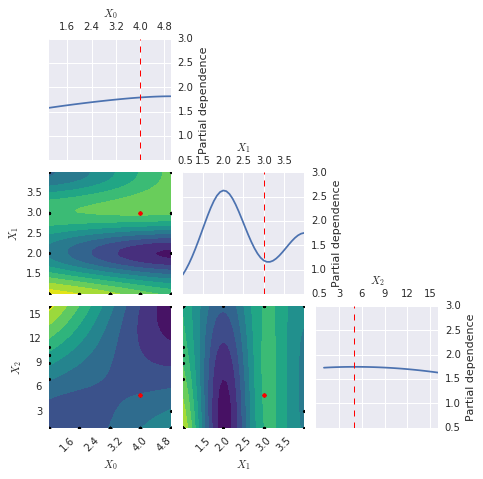

In [21]:
from skopt.plots import plot_convergence, plot_evaluations, plot_objective
fig = plt.figure(figsize=(15,8))
plot_objective(res_gp)
plt.show()

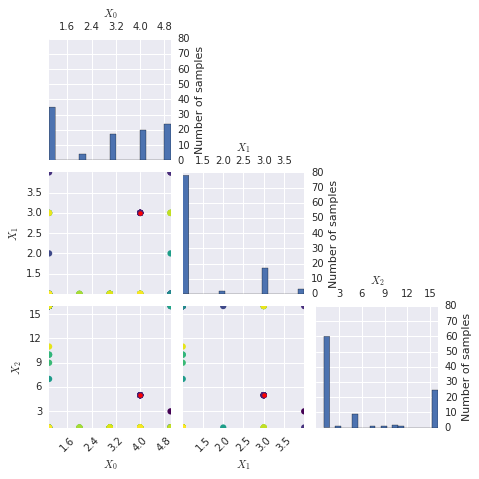

In [23]:
# fig = plt.figure(figsize=(15,8))
plot_evaluations(res_gp)
plt.show()